A notebook for capturing calibration data for the cameras of the OROCHI Simualtor of the Kameda Lab.

Processing of dark frames only at ragne of black levels, to find optimal black level to use.

Load data from PTC99 and PTC5 measurements from 28062023 to use as dummy data, but only look at the dark frame plots.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import orochi_sim_proc as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

colours = plt.get_cmap("tab10")

def process_dtc(dark):
    channels = sorted(list(Path('..', 'data', dark).glob('[!.]*')))

    # gain
    g = 10.0**(4.3 / 20)

    # full well
    fw_exp_os = 32049.0 # expected full well (e-) for OROS
    fw_exp_os_g = fw_exp_os / g # expected full well (e-) for OROS with gain
    fw_exp_of = 20000.0 # expected full well (e-) for OROCHI
    # read noise
    rn_exp_os = 7.07 # expected read noise (e-) for Oro-S
    rn_exp_os_g = rn_exp_os # expected read noise (e-) for Oro-S with gain
    rn_exp_of = 10.0 # expected read noise (e-) for OROCHI
    # sensitivity
    k_exp_os = 7.979 # expected sensitivity in 12-bit mode for Oro-S - Baumer EMVA Study
    k_exp_os_g = k_exp_os / g # expected sensitivity in 12-bit mode for Oro-S with gain
    k_exp_of = fw_exp_of / 2**12 # expected sensitivity in 12-bit mode for OROCHI
    # read noise
    rn_dn_exp_os = rn_exp_os / k_exp_os # expected read noise (DN) for OROS
    rn_dn_exp_os_g = rn_dn_exp_os * g # expected read noise (DN) for OROS with gain
    rn_dn_exp_of = rn_exp_of / k_exp_of # expected read noise (DN) for OROCHI

    # dark current (DN/s) at ~30°C
    dc_exp_os = 8.8 / k_exp_os
    dc_exp_os_g = 8.8 / k_exp_os_g
    dc_exp_of = 2.6 / k_exp_of
    
    fig_var_dn, ax_var_dn = osp.grid_plot() # init the dark variance DN plot
    cntr_var_dn = ax_var_dn[8] # centre plot for overlaying the dark varianct DN

    fig_d_exp, ax_d_exp = osp.grid_plot() # init the dark signal plot
    cntr_d_exp = ax_d_exp[8] # centre plot for overlaying the dark signal
    d_exp_min = 0.0
    d_exp_max = 60

    cameras = ['OROS-OTS', 'OROS', 'OROCHI']
    read_noises = [rn_exp_os, rn_exp_os_g, rn_exp_of]
    dark_currents = [dc_exp_os, dc_exp_os_g, dc_exp_of]

    # colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colours = plt.get_cmap("tab10")

    for channel_path in channels:
        channel = channel_path.name        
        print('--------------------------------------------')
        print(f'Processing {dark}/{channel}')
        # load the calibration target images, and compute the full well, linear sensitivity and read noise
        dtc_data, read_noise, dark_current = osp.load_dtc_frames(dark, channel)        

        # pct_data.sort_values('exposure', inplace=True)
        num = int(channel.split('_')[0]) # get camera number
        wvl = int(channel.split('_')[1]) # get camera wavelength        
        chnl_str = f'Camera {num}: {wvl} nm' # create channel string
        
        colour = colours(num) # get colour for channel

        # plot temporal dark variance against Exposure
        # data
        ax_var_dn[num].loglog(dtc_data['exposure'], dtc_data['std_rs'], '.', label=chnl_str, color=colour)            
        cntr_var_dn.loglog(dtc_data['exposure'], dtc_data['std_rs'], '.', label='All Channels', color=colour)            
        # fit
        ax_var_dn[num].axhline(read_noise, linestyle='solid', color=colour, label='Fit')
        cntr_var_dn.axhline(read_noise, linestyle='solid', color=colour, label='Fit')        
        fit_std_rs = np.sqrt(read_noise**2 + (dark_current * dtc_data['exposure'] / k_exp_os_g))
        ax_var_dn[num].loglog(dtc_data['exposure'], fit_std_rs, linestyle='solid', color=colour, label='Fit')
        cntr_var_dn.loglog(dtc_data['exposure'], fit_std_rs, linestyle='solid', color=colour, label='Fit')
        # expected
        oros_g_exp_std_rs = np.sqrt(rn_dn_exp_os_g**2 + (dc_exp_os_g * dtc_data['exposure'] / k_exp_os_g))        
        oros_exp_std_rs = np.sqrt(rn_dn_exp_os**2 + (dc_exp_os * dtc_data['exposure'] / k_exp_os))
        of_exp_std_rs = np.sqrt(rn_dn_exp_of**2 + (dc_exp_of * dtc_data['exposure'] / k_exp_of))        
        ax_var_dn[num].axhline(rn_dn_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')
        ax_var_dn[num].loglog(dtc_data['exposure'], oros_g_exp_std_rs, linestyle='dashed', color='k', label='OROS (g)')
        # labels
        ax_var_dn[num].set_title(chnl_str)
        ax_var_dn[num].set_ylabel('Temporal Dark Noise (DN)')
        ax_var_dn[num].set_xlabel('Exposure (s)')

        # plot Dark Signal vs Exposure
        ax_d_exp[num].plot(dtc_data['exposure'], dtc_data['mean'], '.', label=chnl_str, color=colour)            
        cntr_d_exp.plot(dtc_data['exposure'], dtc_data['mean'], '.', label='All Channels', color=colour)            
        ax_d_exp[num].set_title(chnl_str)
        cntr_d_exp.set_title('All Channels')
        exp_dark = dark_current * dtc_data['exposure']
        ax_d_exp[num].plot(dtc_data['exposure'], exp_dark, linestyle='solid', color=colour, label='exp')                
        cntr_d_exp.plot(dtc_data['exposure'], exp_dark, linestyle='solid', color=colour, label='exp')
        ax_d_exp[num].plot(dtc_data['exposure'], (dc_exp_os_g/k_exp_os_g)*dtc_data['exposure'], linestyle='dashed', color='k', label='OROS (g)')
        ax_d_exp[num].set_ylabel('Dark Signal (DN)')
        ax_d_exp[num].set_xlabel('Exposure (s)')
        cntr_d_exp.set_ylabel('Dark Signal (DN)')
        cntr_d_exp.set_xlabel('Exposure (s)')
       
        # add extracted full well, gain and read-noise to the plots

        cameras.append(chnl_str)
        read_noises.append(read_noise)
        dark_currents.append(dark_current)
        print('--------------------------------------------')
        # print electron full well      
    cntr_var_dn.axhline(y=rn_dn_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')
    cntr_var_dn.axhline(y=rn_dn_exp_os, linestyle='dotted', color='k', label='OROS')
    cntr_var_dn.axhline(y=rn_dn_exp_of, linestyle='solid', color='k', label='OROCHI')
    cntr_var_dn.loglog(dtc_data['exposure'], oros_g_exp_std_rs, linestyle='dashed', color='k', label='OROS (g)')
    cntr_var_dn.loglog(dtc_data['exposure'], oros_exp_std_rs, linestyle='dotted', color='k', label='OROS')
    cntr_var_dn.loglog(dtc_data['exposure'], of_exp_std_rs, linestyle='solid', color='k', label='OROCHI')
    cntr_var_dn.set_title('All Channels')
    cntr_var_dn.set_ylabel('Temporal Dark Noise (DN)')
    cntr_var_dn.set_xlabel('Exposure (s)')
    osp.show_grid(fig_var_dn, ax_var_dn) 

    d_exp_min, d_exp_max = cntr_d_exp.get_xlim()
    cntr_d_exp.plot([d_exp_min, d_exp_max], (dc_exp_os_g/k_exp_os_g)*np.array([d_exp_min, d_exp_max]), linestyle='dashed', color='k', label='OROS (g)')
    cntr_d_exp.plot([d_exp_min, d_exp_max], (dc_exp_os/k_exp_os)*np.array([d_exp_min, d_exp_max]), linestyle='dotted', color='k', label='OROS')
    cntr_d_exp.plot([d_exp_min, d_exp_max], (dc_exp_of/k_exp_of)*np.array([d_exp_min, d_exp_max]), linestyle='solid', color='k', label='OROCHI')
    osp.show_grid(fig_d_exp, ax_d_exp)

    results = pd.DataFrame({'camera': cameras, 'read_noise': read_noises, 'dark_current': dark_currents})
    return results

bias:  0
--------------------------------------------
Processing dark_dense_0_290623/0_850
Loaded 1 images (850_10095570us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_10095570us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_104us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_104us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_105828us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_105828us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_1109us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_1109us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_1132285us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_1132285us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_11869us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_11869us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_12114684us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_12114684us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_124us_1_calibration) for: 0 (850 nm)

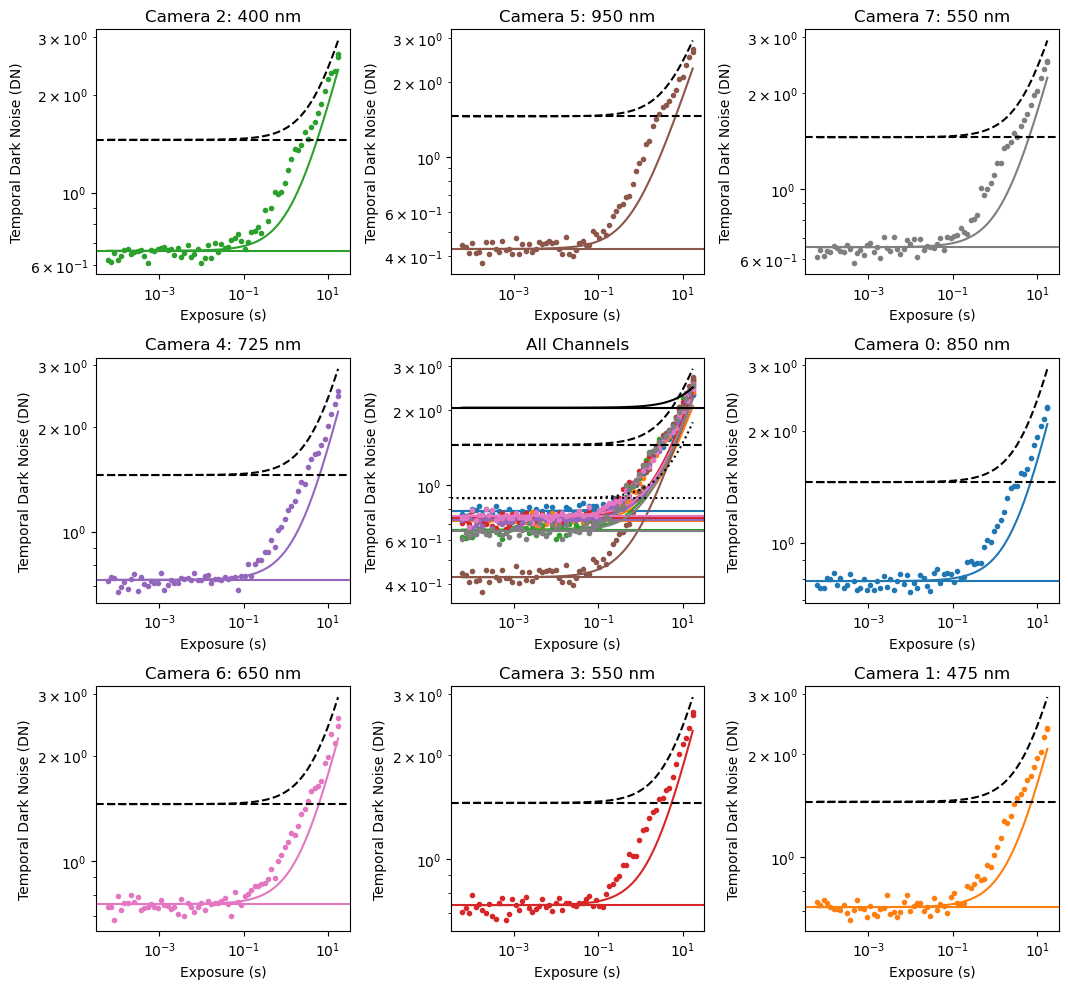

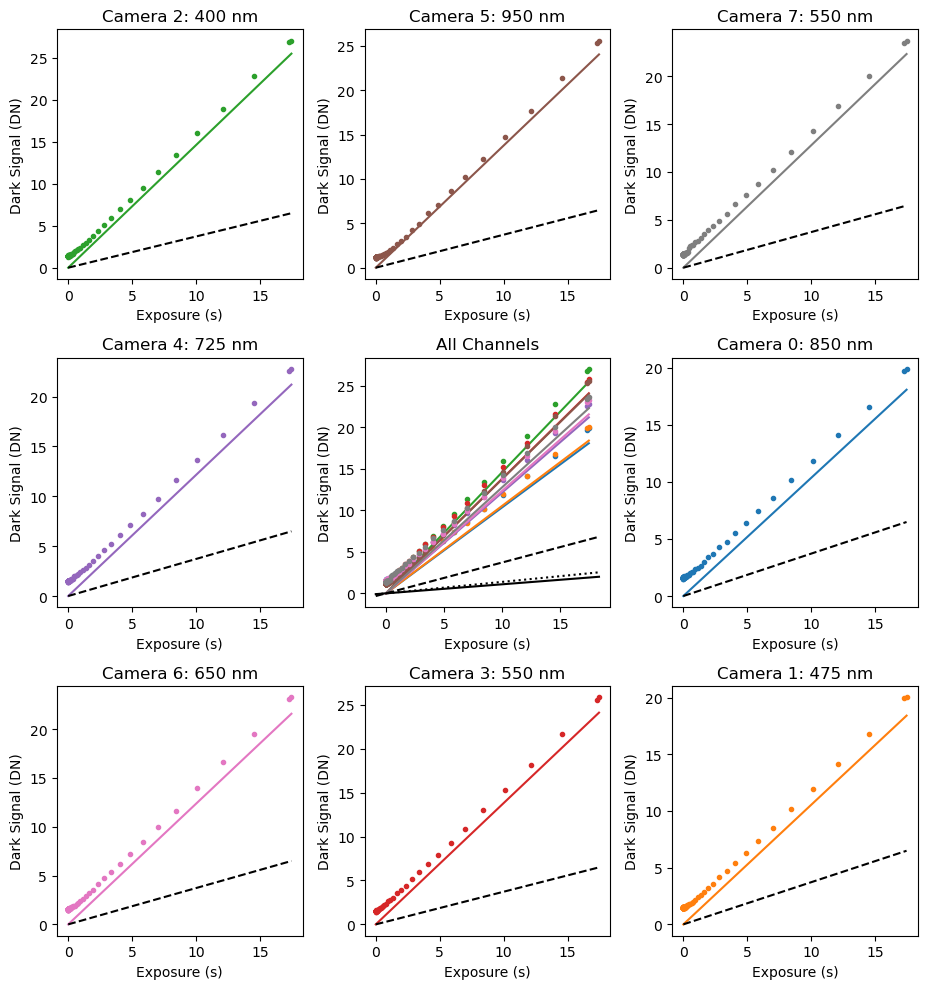

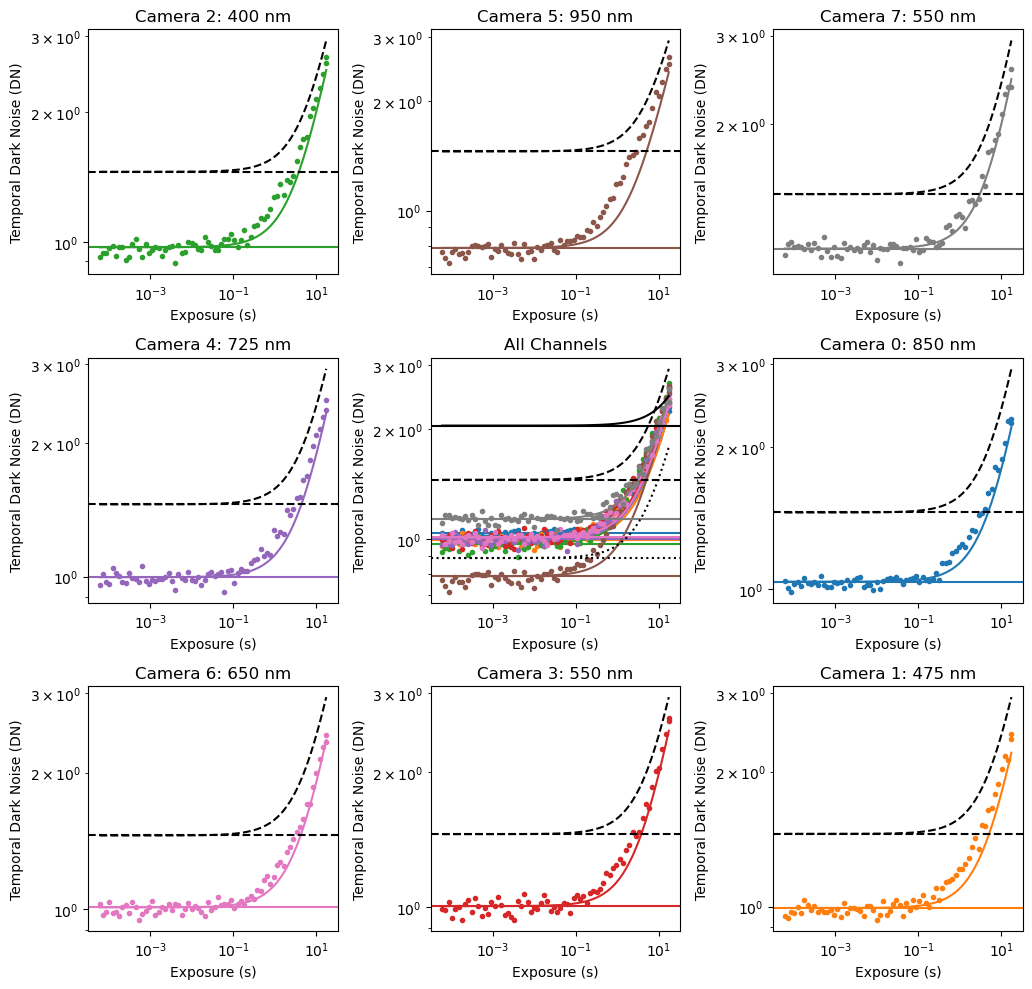

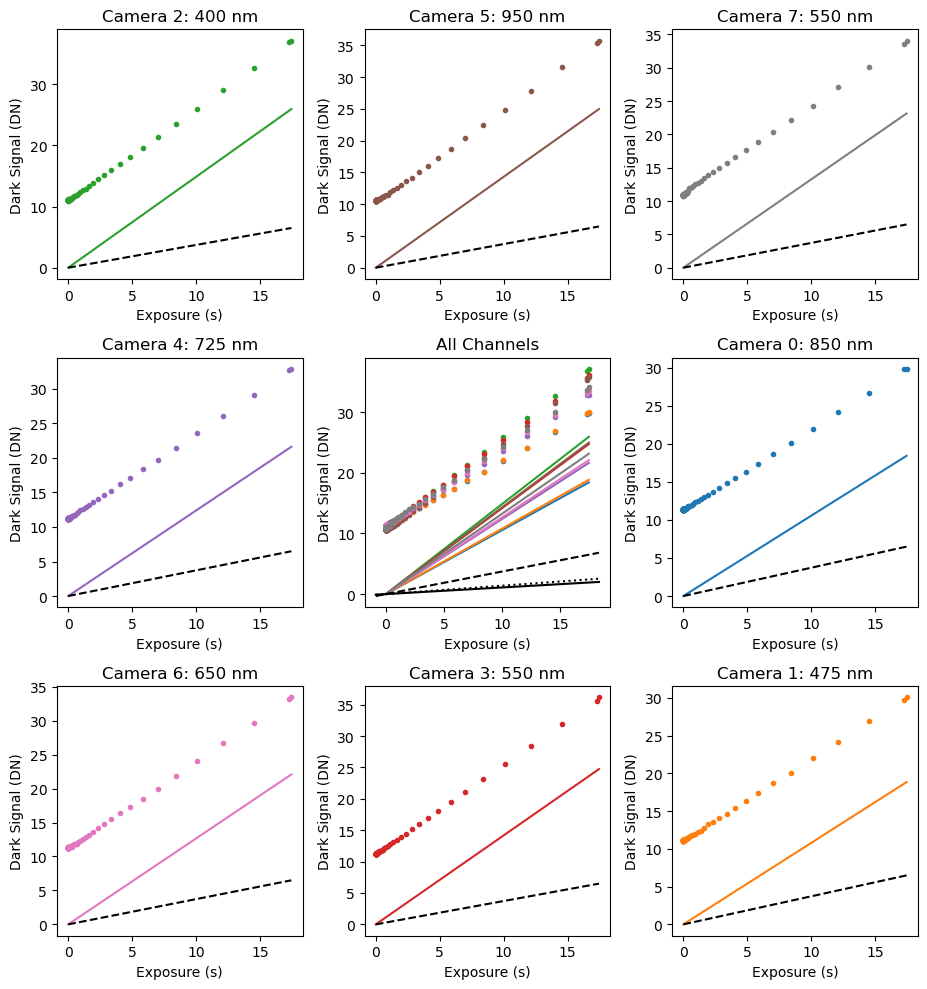

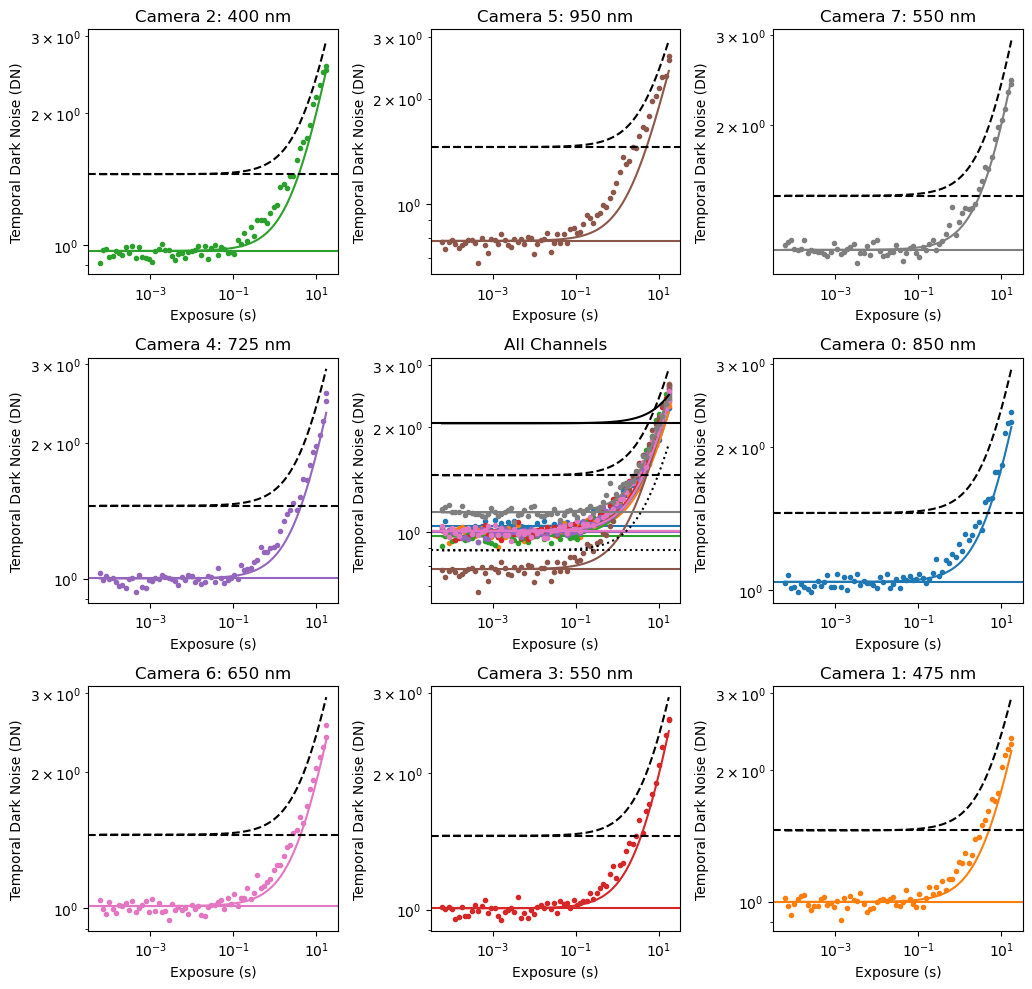

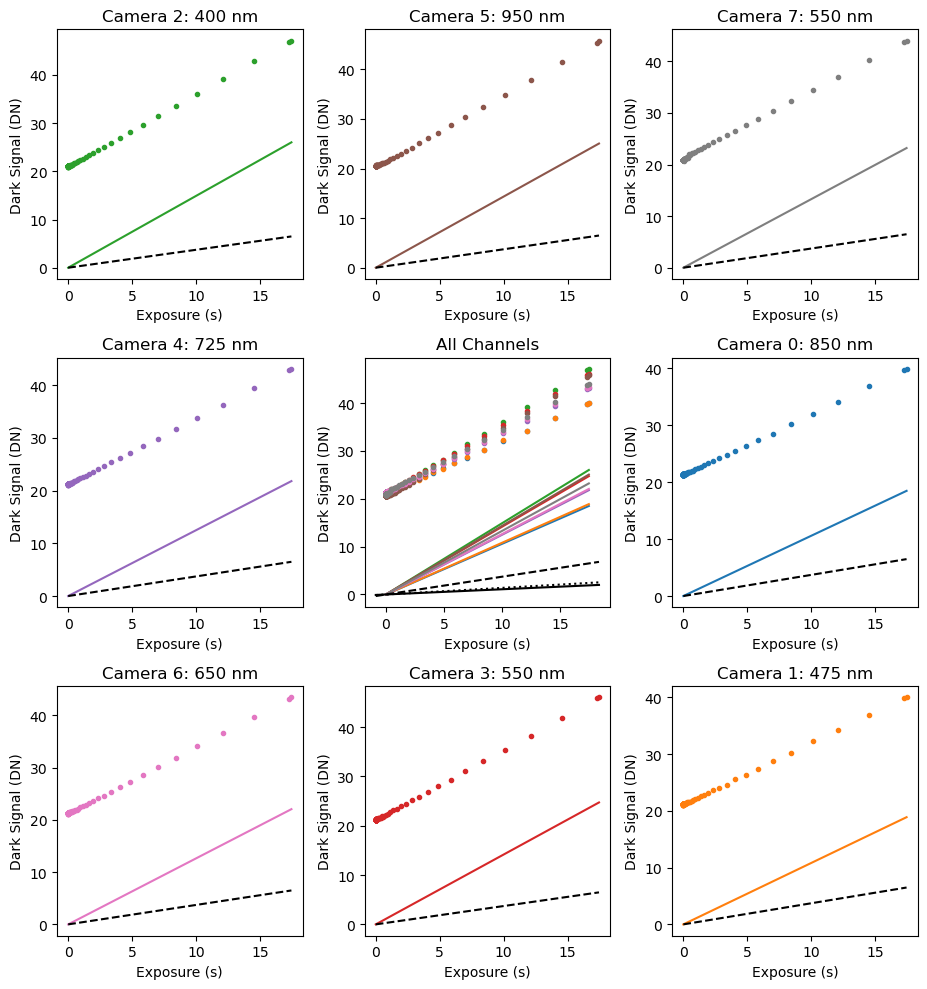

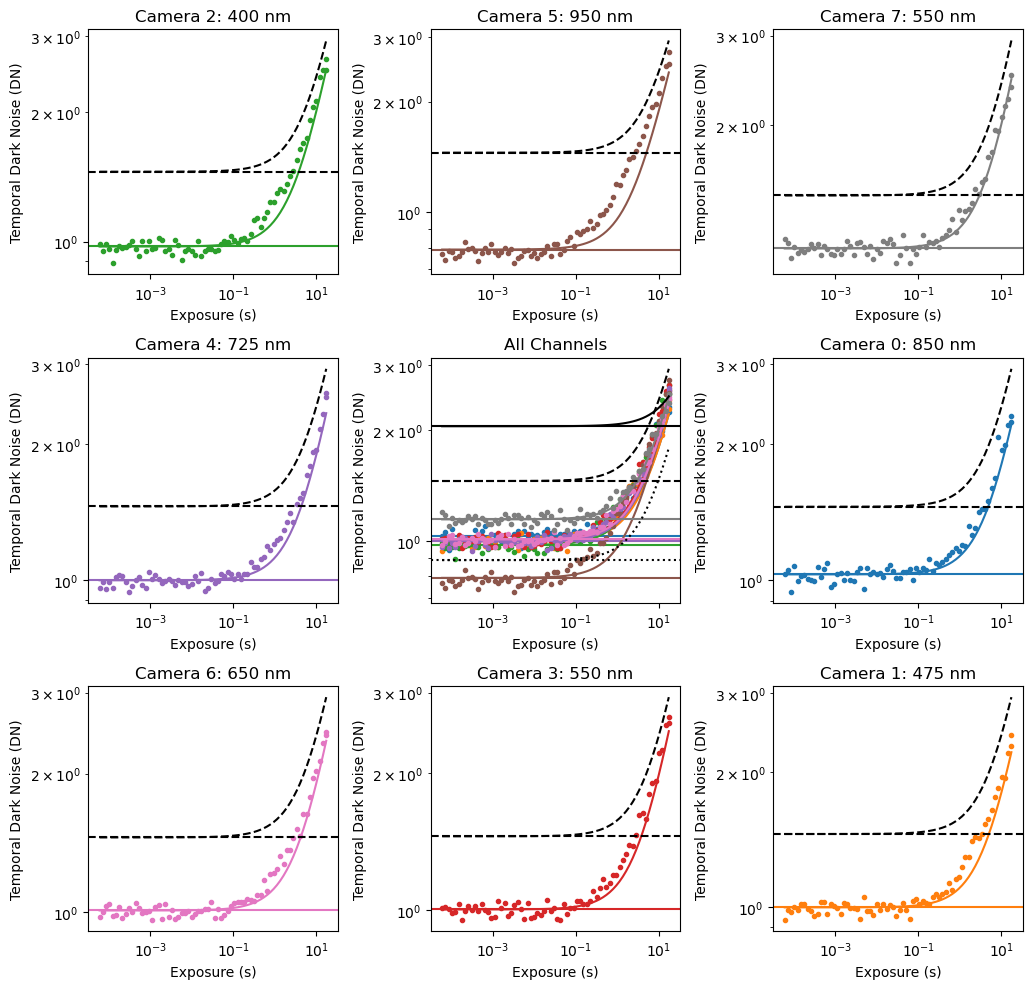

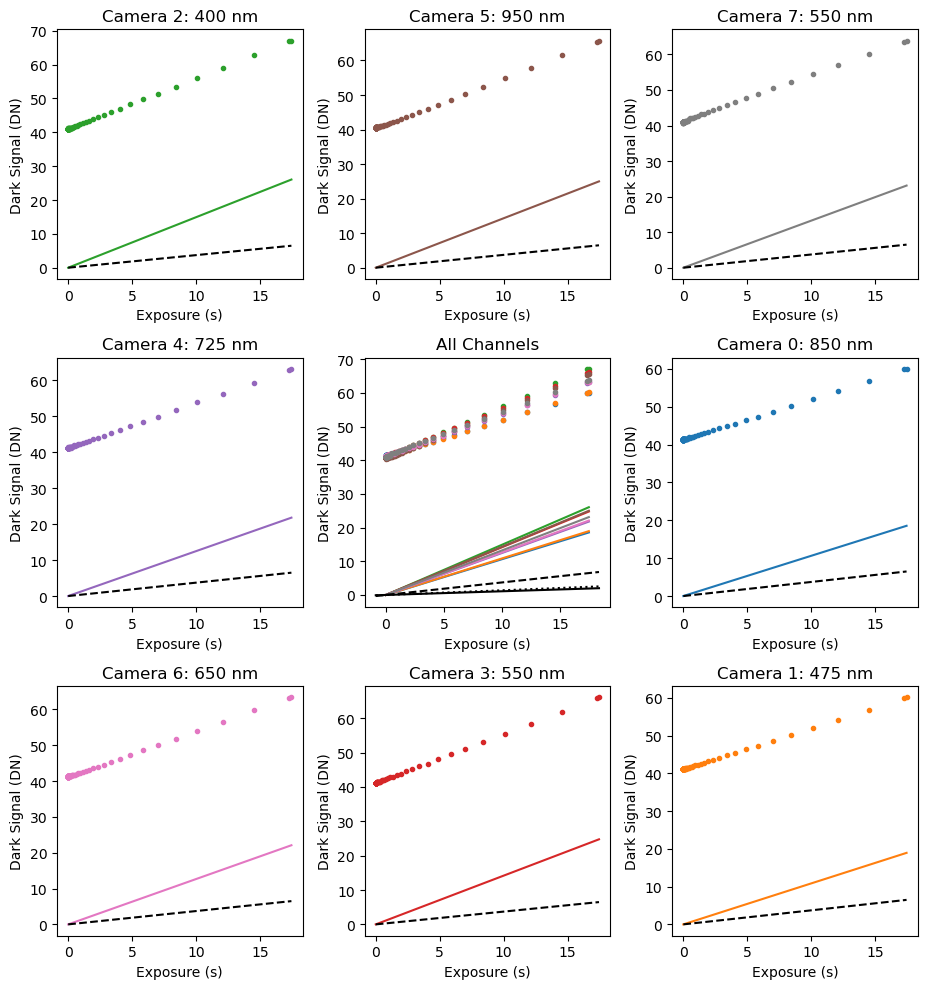

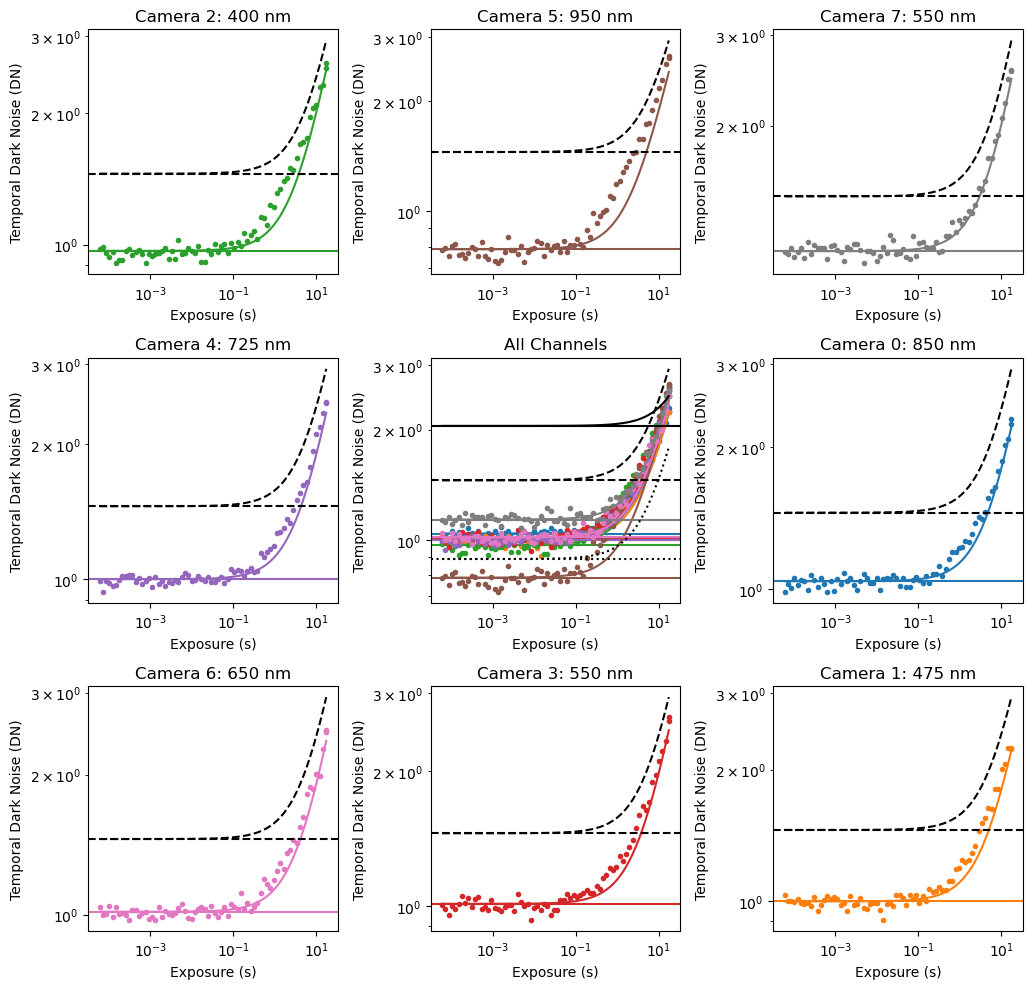

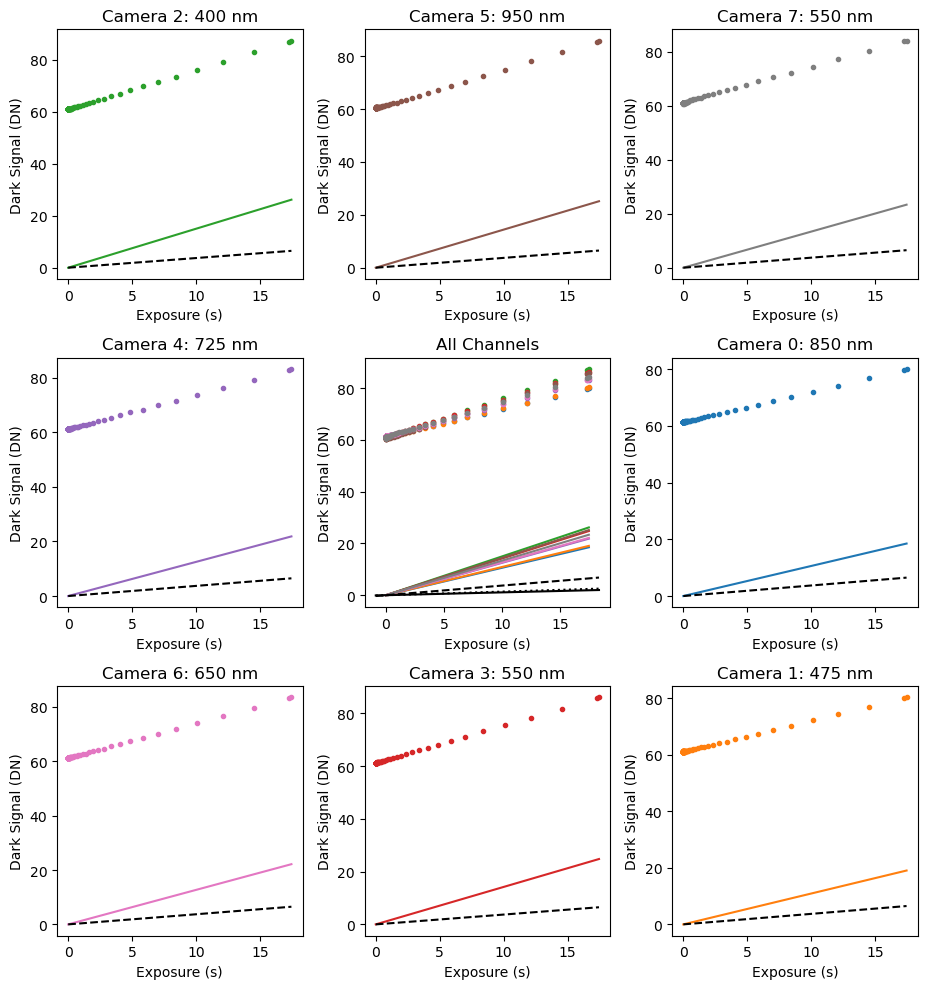

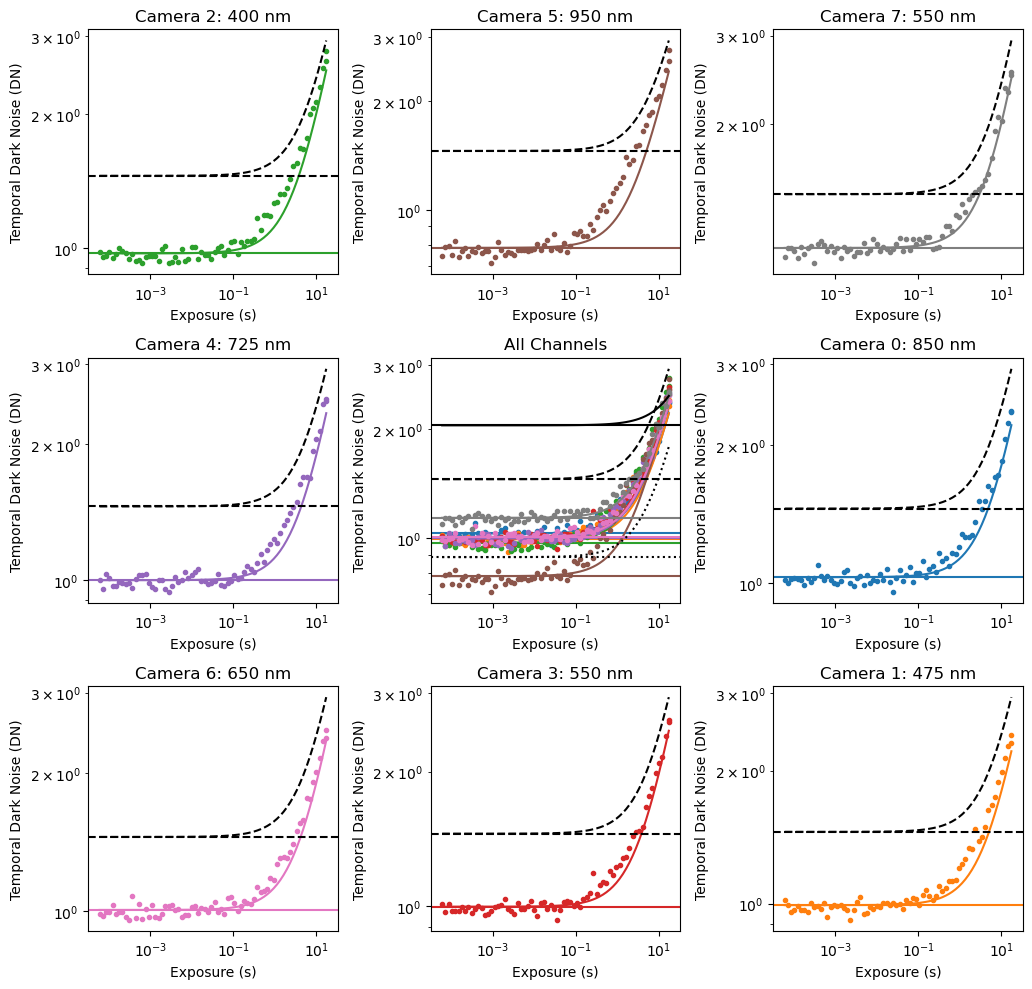

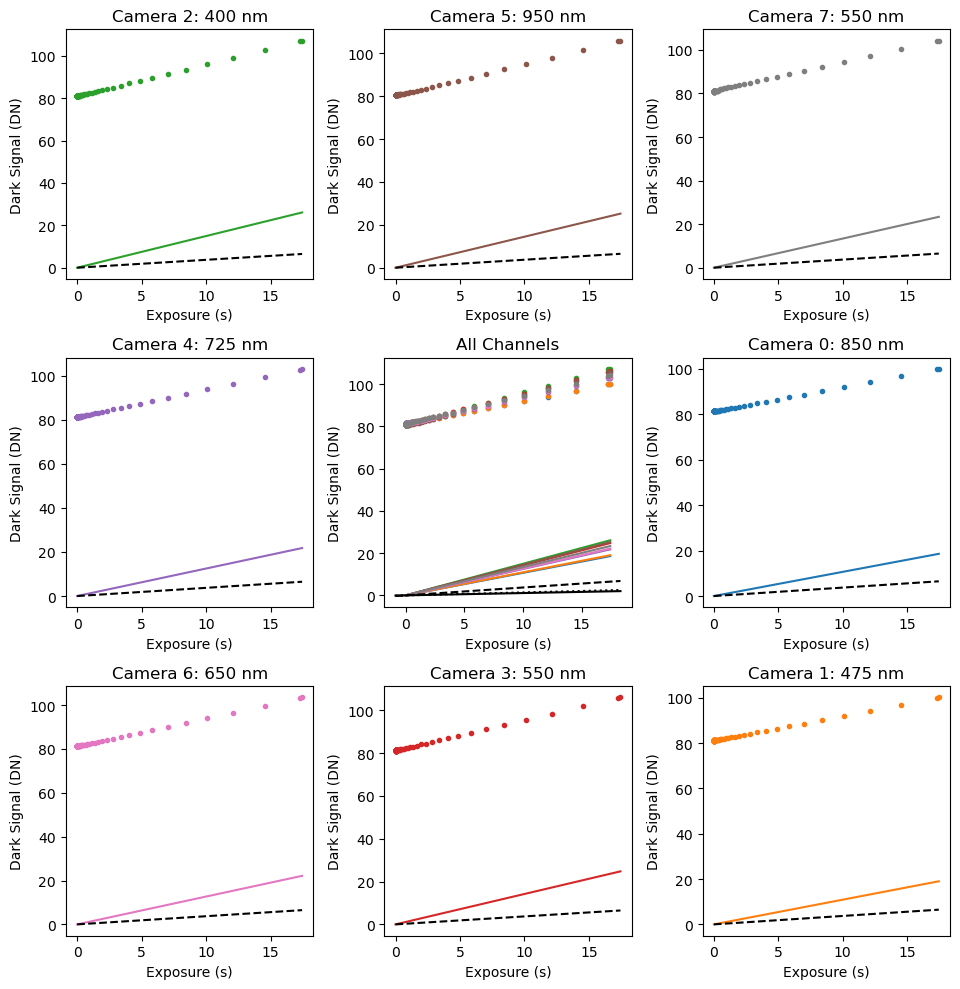

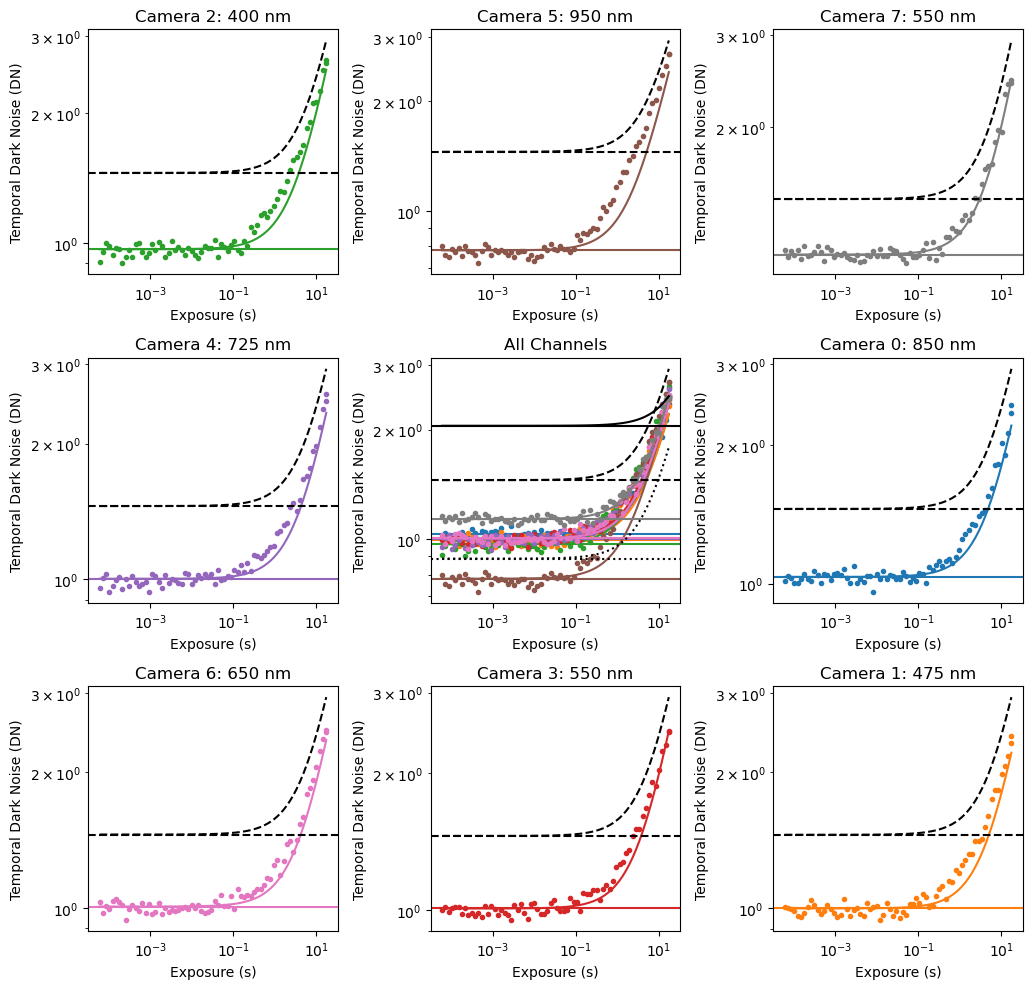

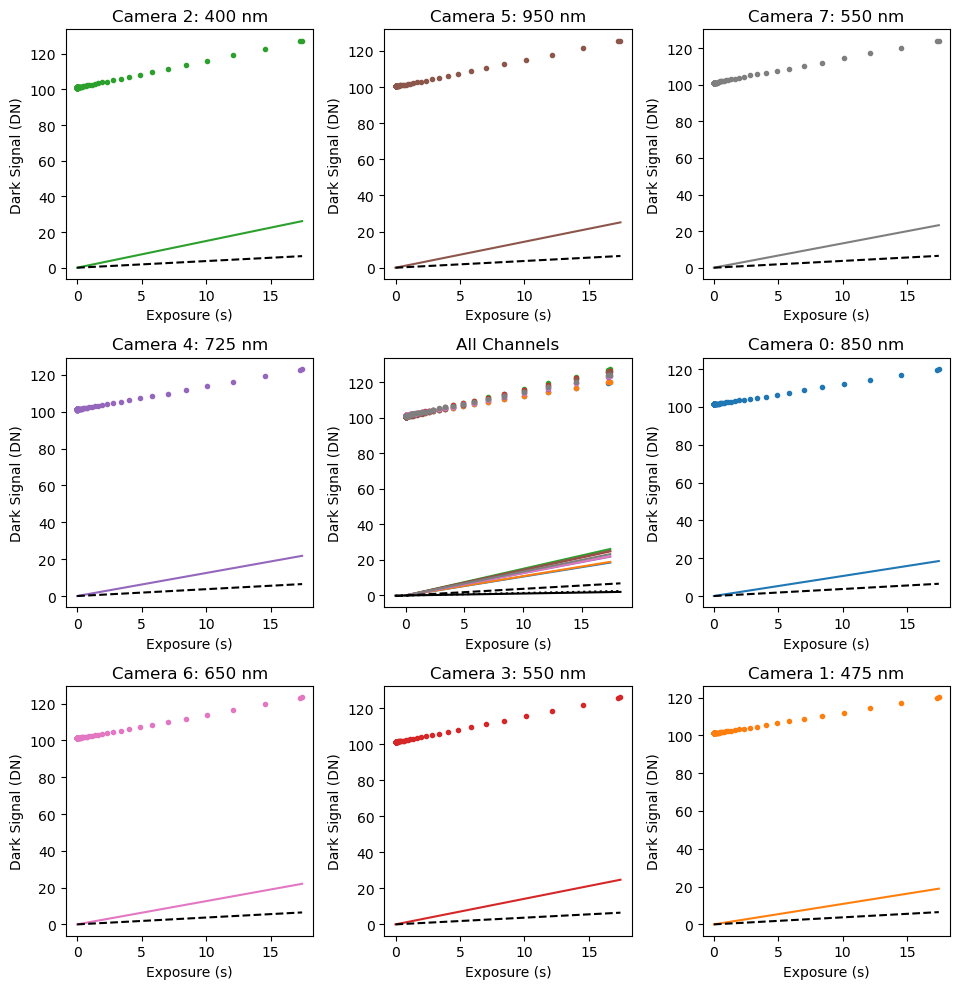

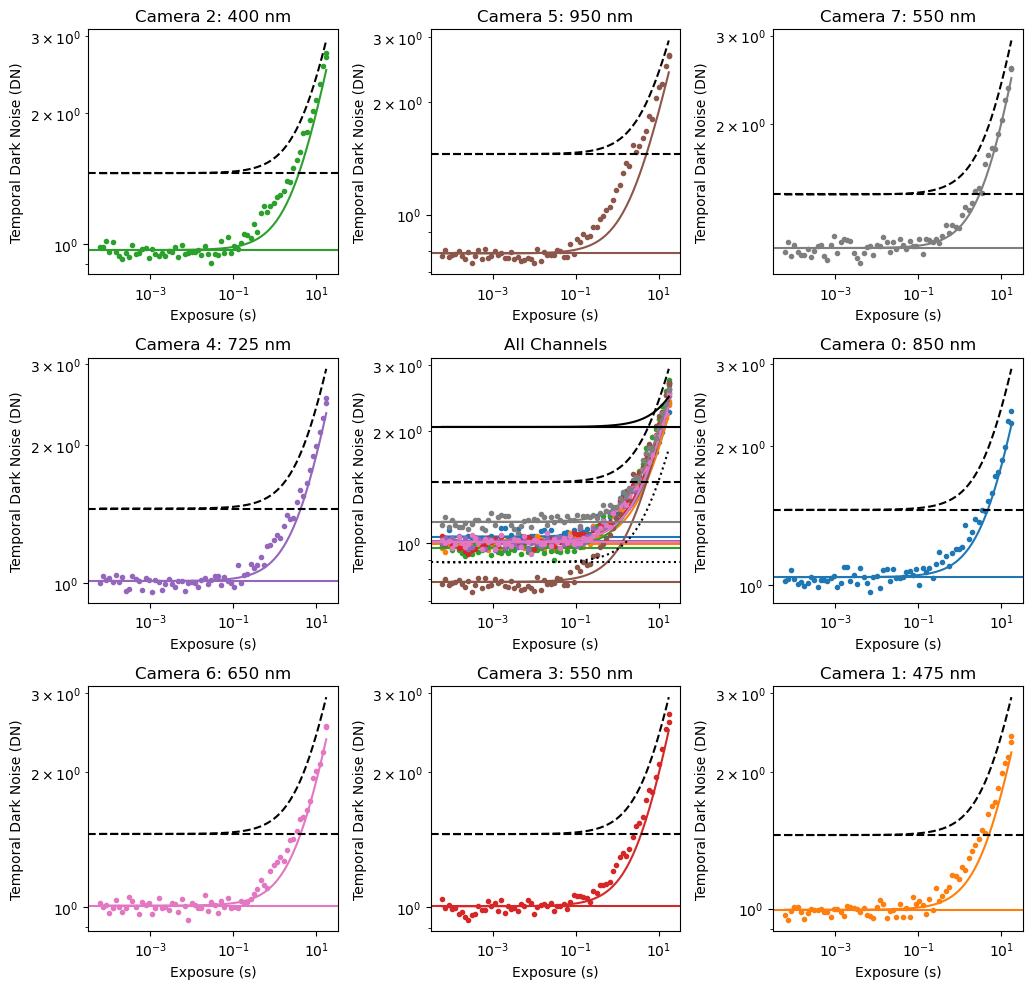

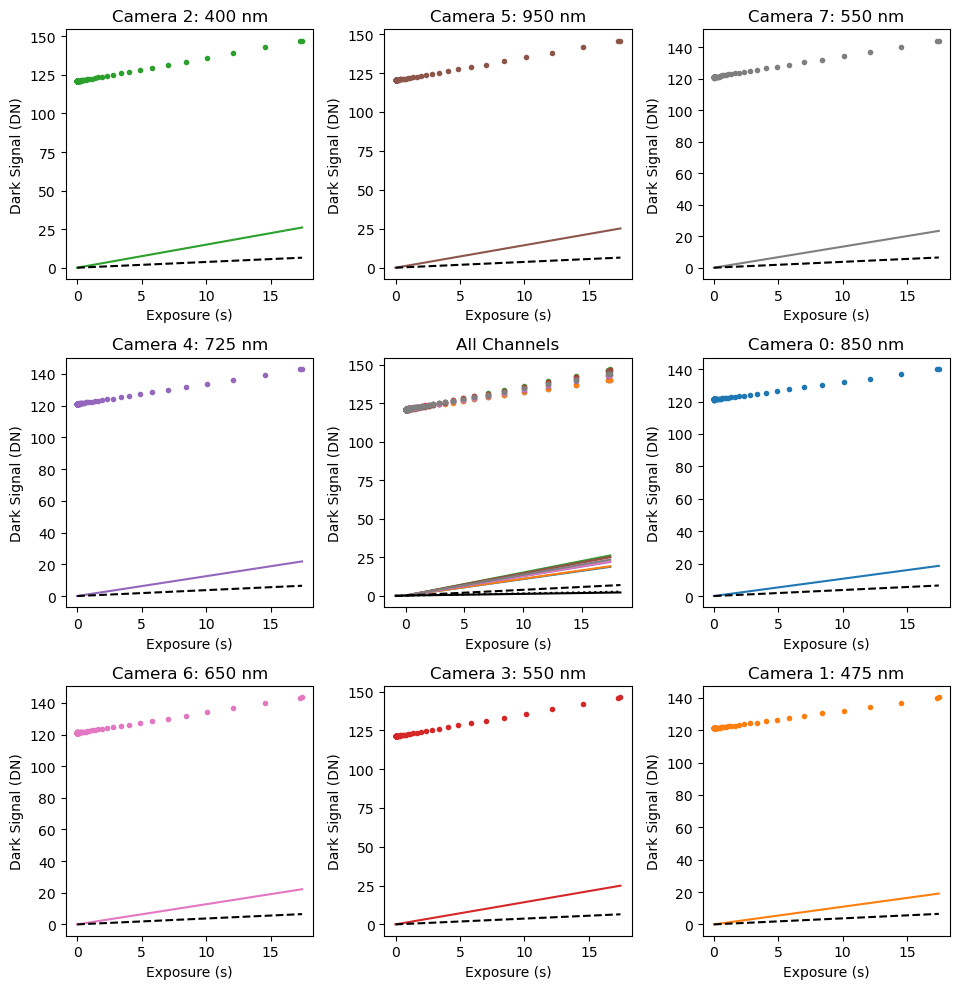

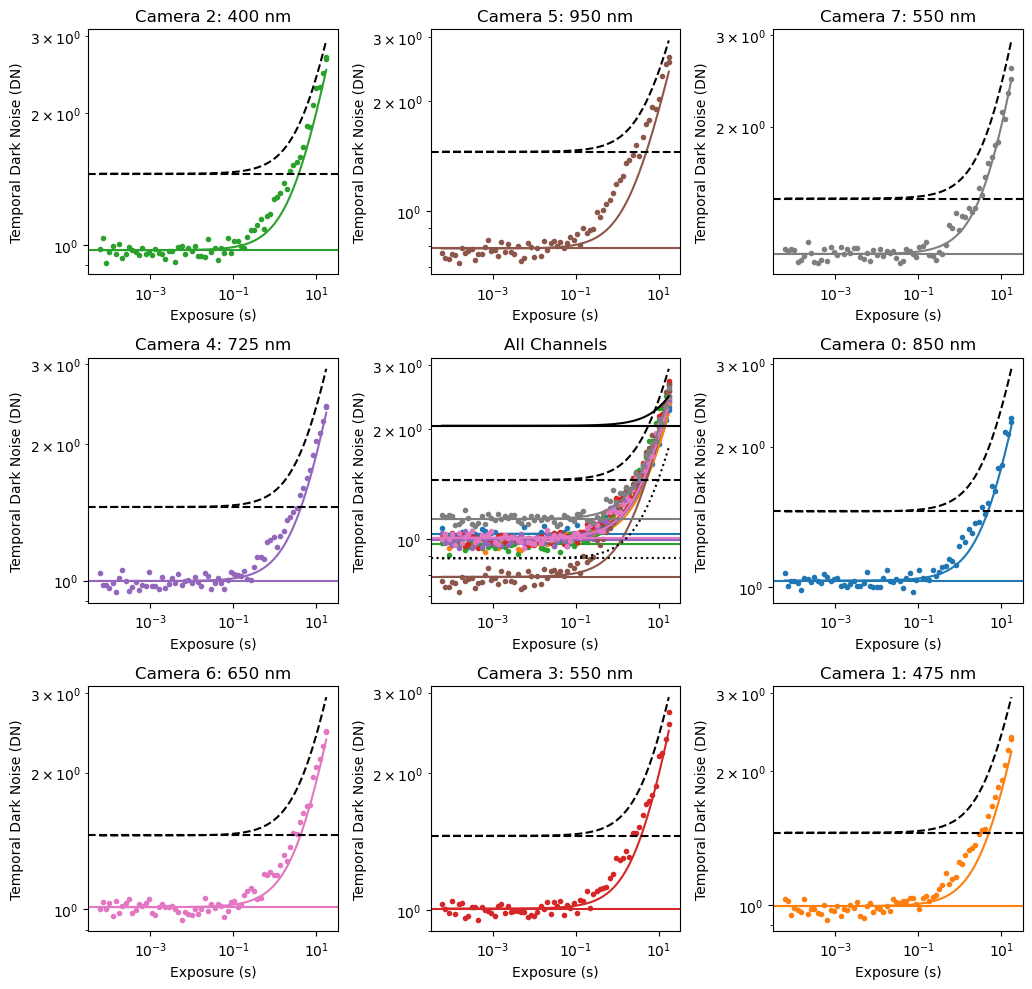

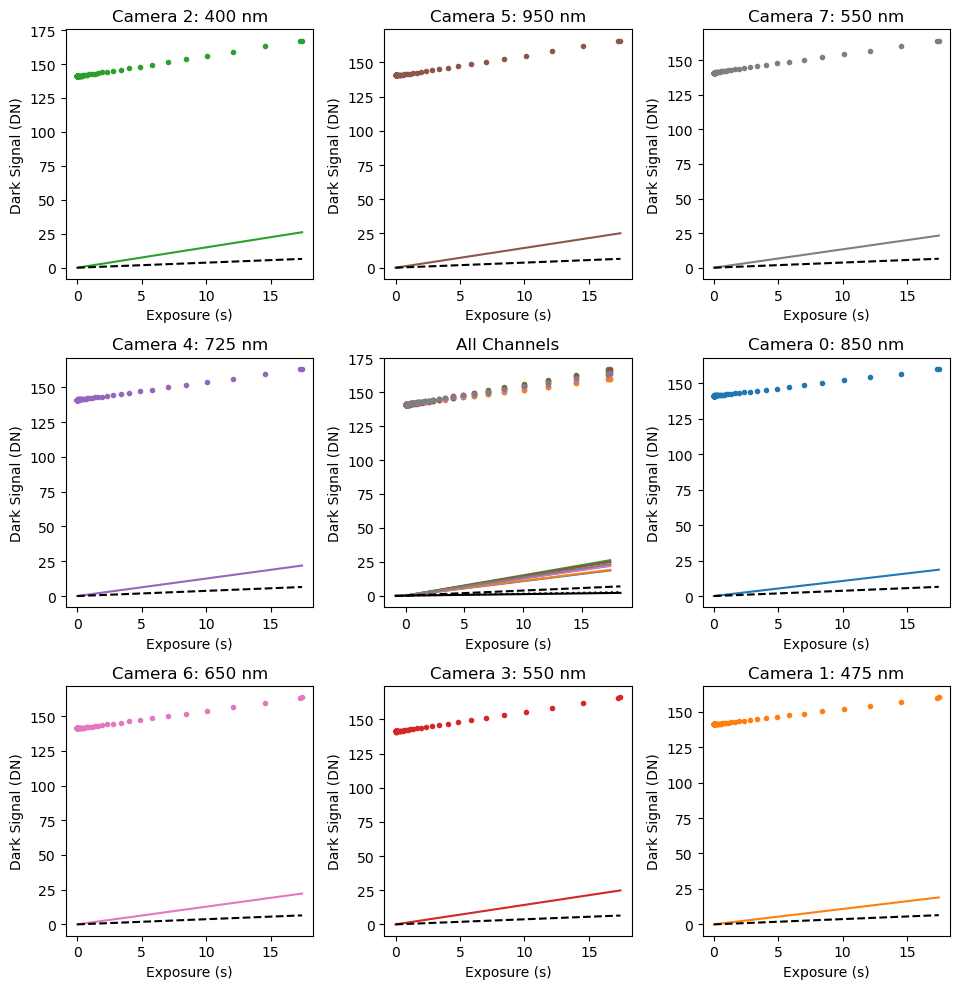

In [3]:
black_levels = [0, 10, 20, 40, 60, 80, 100, 120, 140]
read_noise = {}
dark_current = {}
for black_level in black_levels:
    dark = f'dark_dense_{black_level}_290623'
    print('bias: ', black_level)
    results = process_dtc(dark)
    read_noise[black_level] = results['read_noise']
    dark_current[black_level] = results['dark_current']
    

For each channel , get the read noise results and plot against bias level.

--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------


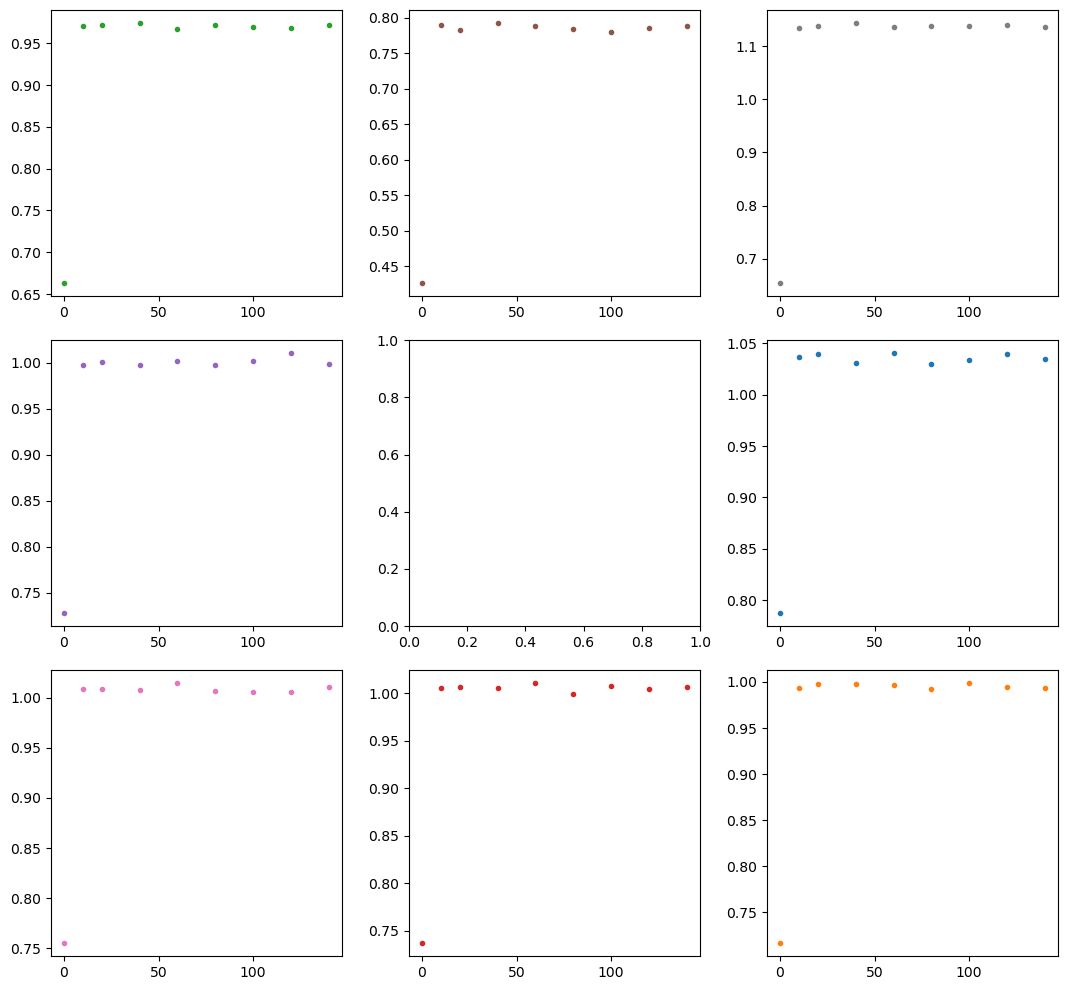

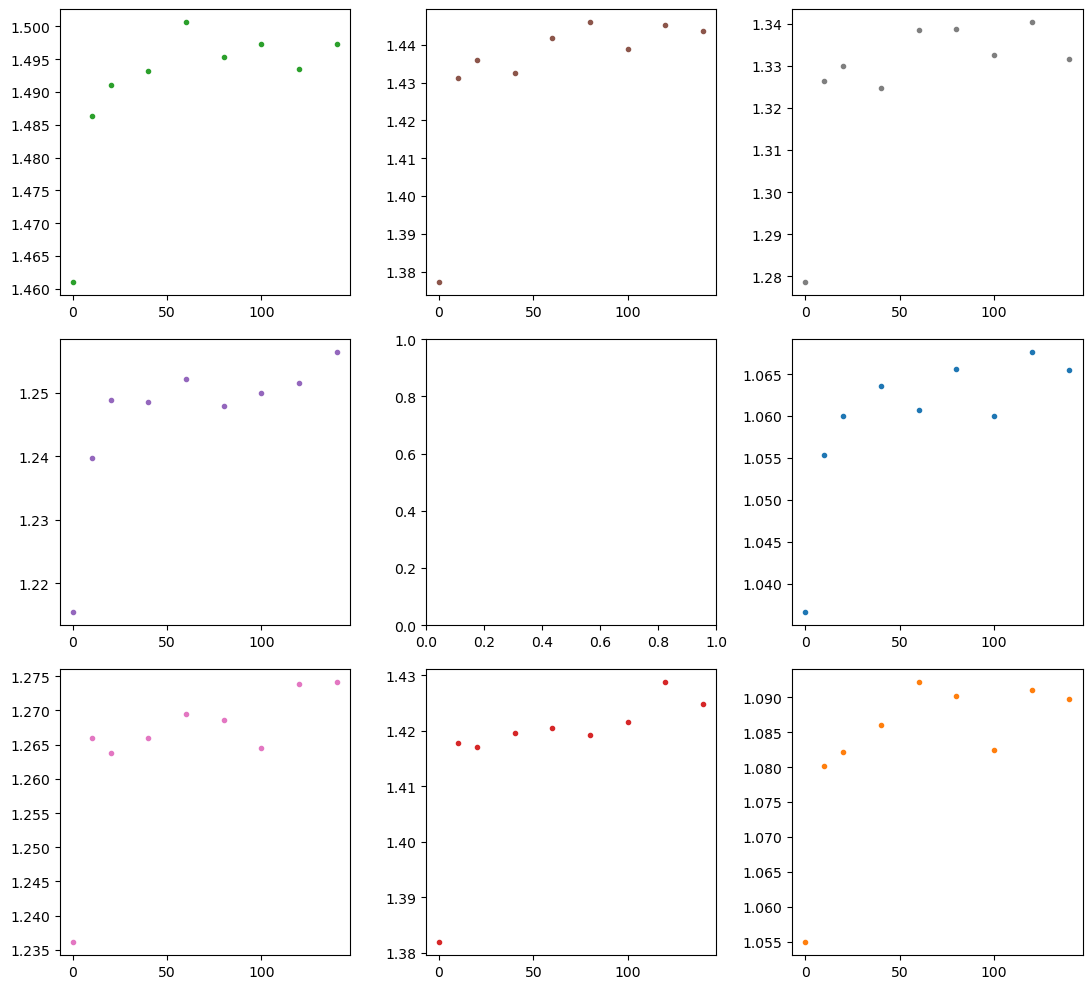

In [4]:
fig_b_exp, ax_b_exp = osp.grid_plot() # init the dark signal plot
cntr_b_exp = ax_b_exp[8] # centre plot for overlaying the dark signal

fig_dc_exp, ax_dc_exp = osp.grid_plot() # init the dark signal plot
cntr_dc_exp = ax_dc_exp[8] # centre plot for overlaying the dark signal

cameras = ['OROS-OTS', 'OROS', 'OROCHI']

channels = sorted(list(Path('..', 'data', dark).glob('[!.]*')))

black_levels = [0, 10, 20, 40, 60, 80, 100, 120, 140]

rn_df = pd.DataFrame(read_noise)
rn_df.index = results['camera']

dc_df = pd.DataFrame(dark_current)
dc_df.index = results['camera']

for channel_path in channels:
    channel = channel_path.name        
    print('--------------------------------------------')

    num = int(channel.split('_')[0]) # get camera number
    wvl = int(channel.split('_')[1]) # get camera wavelength        
    chnl_str = f'Camera {num}: {wvl} nm' # create channel string
    
    colour = colours(num) # get colour for channel
    # plot Dark Signal vs Exposure
    ax_b_exp[num].plot(black_levels, rn_df.loc[chnl_str], '.', label=chnl_str, color=colour)            
    # cntr_d_exp.plot(dtc_data['exposure'], dtc_data['mean'], '.', label='All Channels', color=colour)            
    # ax_d_exp[num].set_title(chnl_str)
    # cntr_d_exp.set_title('All Channels')
    # exp_dark = dark_current * dtc_data['exposure']
    # ax_d_exp[num].plot(dtc_data['exposure'], exp_dark, linestyle='solid', color=colour, label='exp')                
    # cntr_d_exp.plot(dtc_data['exposure'], exp_dark, linestyle='solid', color=colour, label='exp')
    # ax_d_exp[num].plot(dtc_data['exposure'], (dc_exp_os_g/k_exp_os_g)*dtc_data['exposure'], linestyle='dashed', color='k', label='OROS (g)')
    # ax_d_exp[num].set_ylabel('Dark Signal (DN)')
    # ax_d_exp[num].set_xlabel('Exposure (s)')
    # cntr_d_exp.set_ylabel('Dark Signal (DN)')
    # cntr_d_exp.set_xlabel('Exposure (s)')

    ax_dc_exp[num].plot(black_levels, dc_df.loc[chnl_str], '.', label=chnl_str, color=colour)    
osp.show_grid(fig_b_exp, ax_b_exp)
osp.show_grid(fig_dc_exp, ax_dc_exp)

Coarsely, what we're seeing here is that optimal bias is somehwere between 0 and 10.

We see dark current increases slightly, but it is also plausible that this is due to gradual warming of the cameras over time.

Note that read noise increase plausibly is also due to this.

Let's run an experiment of 11 bias levels, 10 -> 0, starting with the highest, to see if there is a time direciton.

bias:  10
--------------------------------------------
Processing dark_low_10_300623/0_850
Loaded 1 images (850_10095570us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_10095570us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_104us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_104us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_105828us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_105828us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_1109us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_1109us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_1132285us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_1132285us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_11869us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_11869us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_12114684us_1_calibration) for: 0 (850 nm)
Loaded 1 images (850_12114684us_2_calibration) for: 0 (850 nm)
Loaded 1 images (850_124us_1_calibration) for: 0 (850 nm)

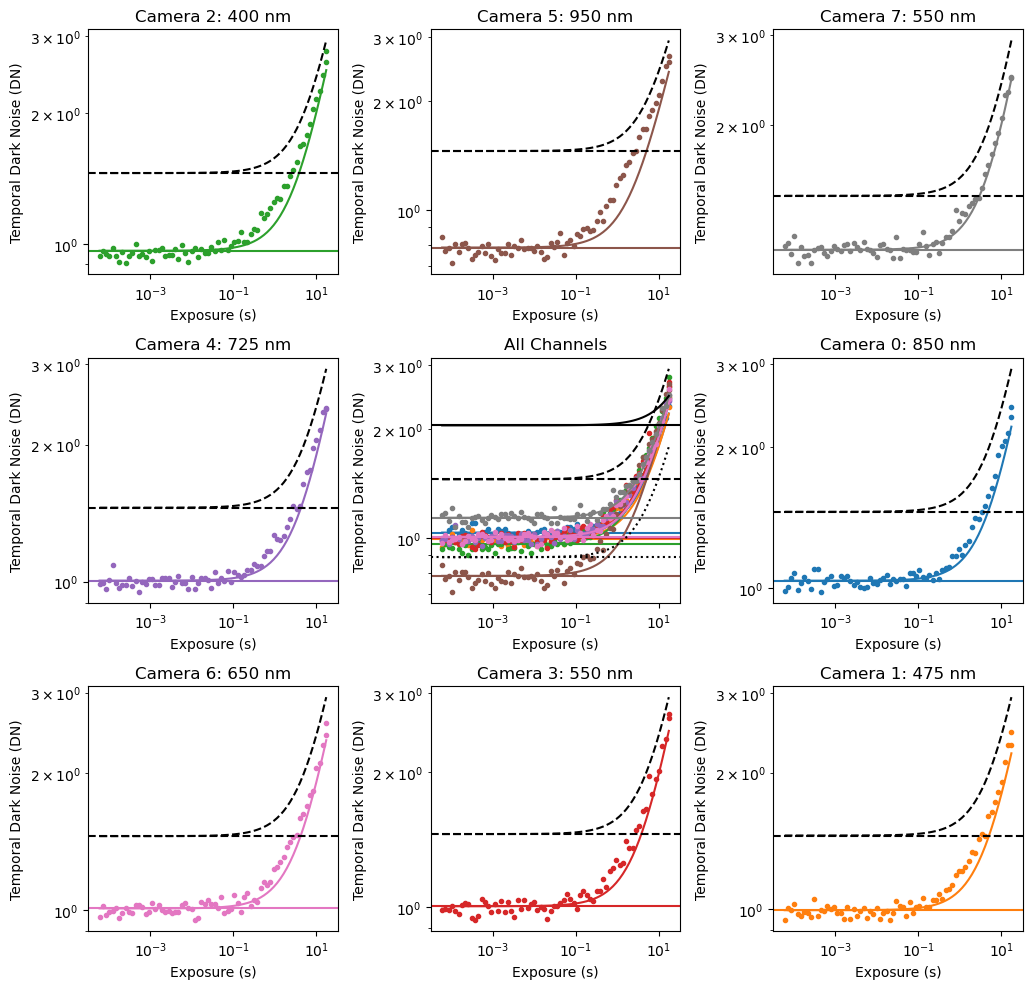

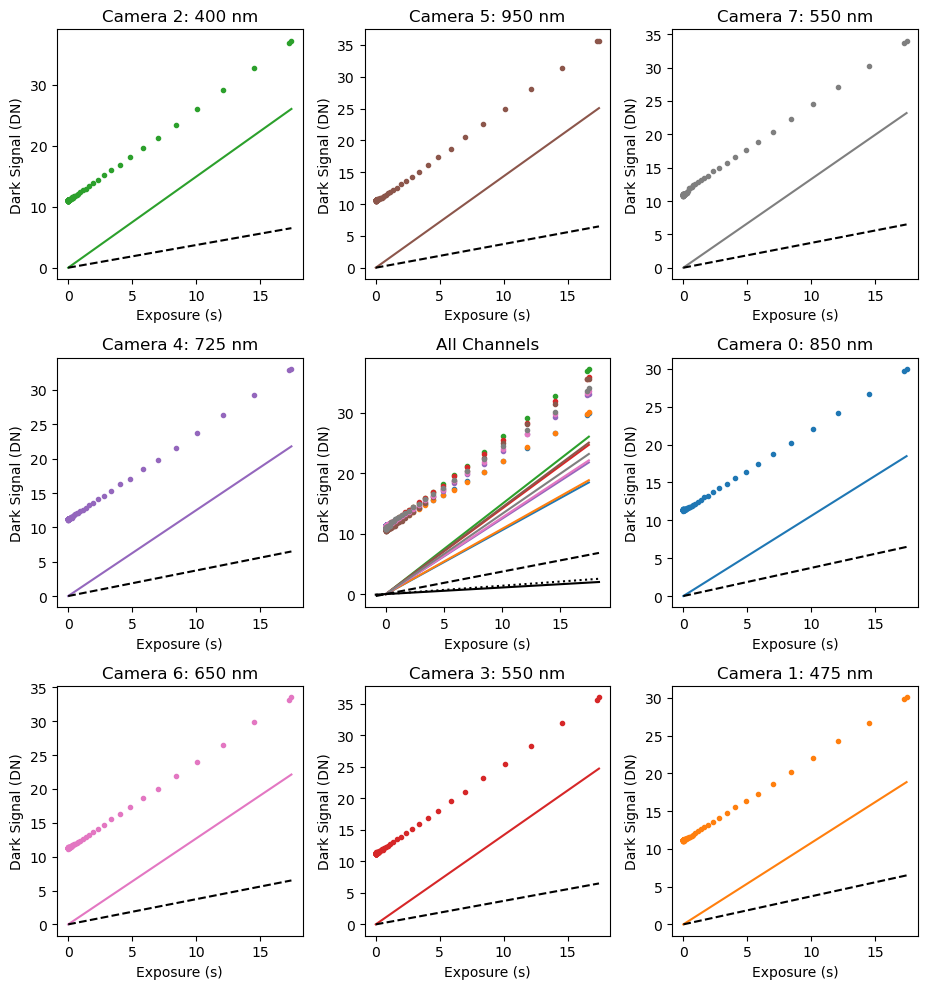

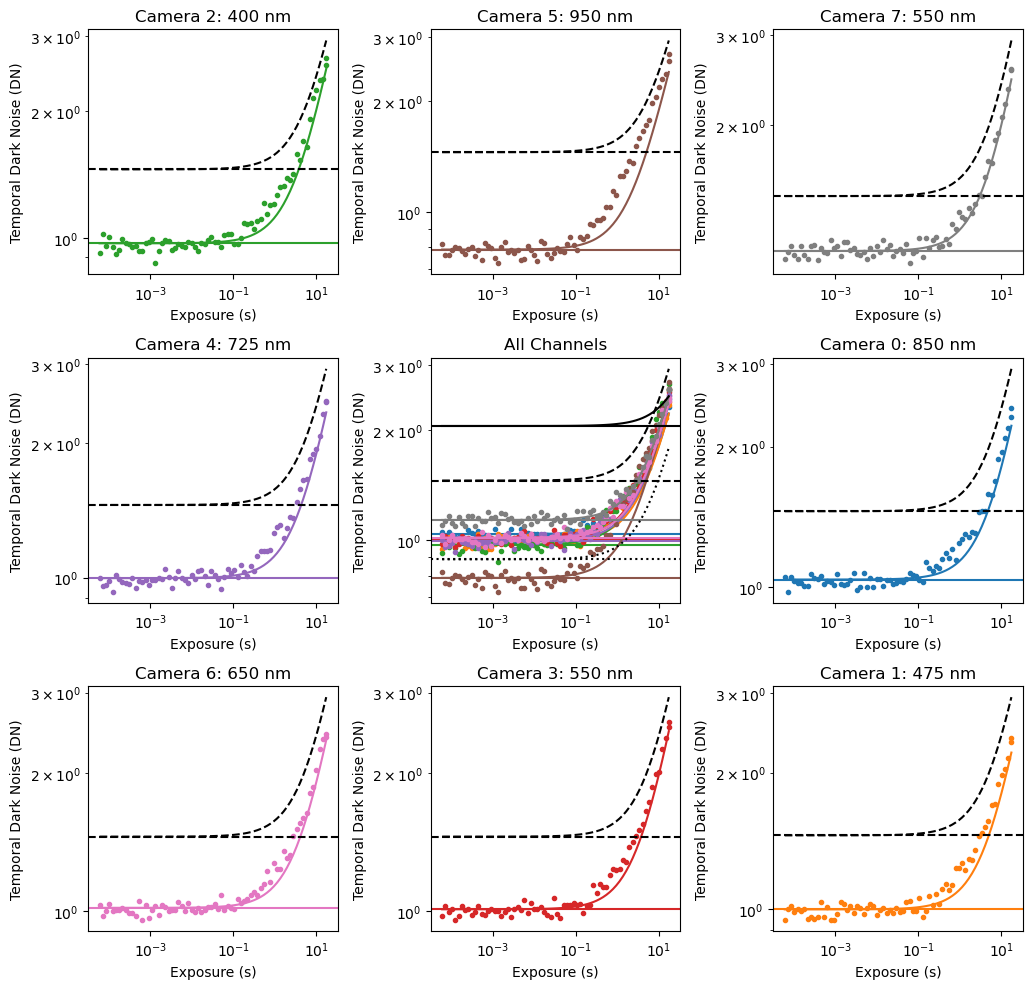

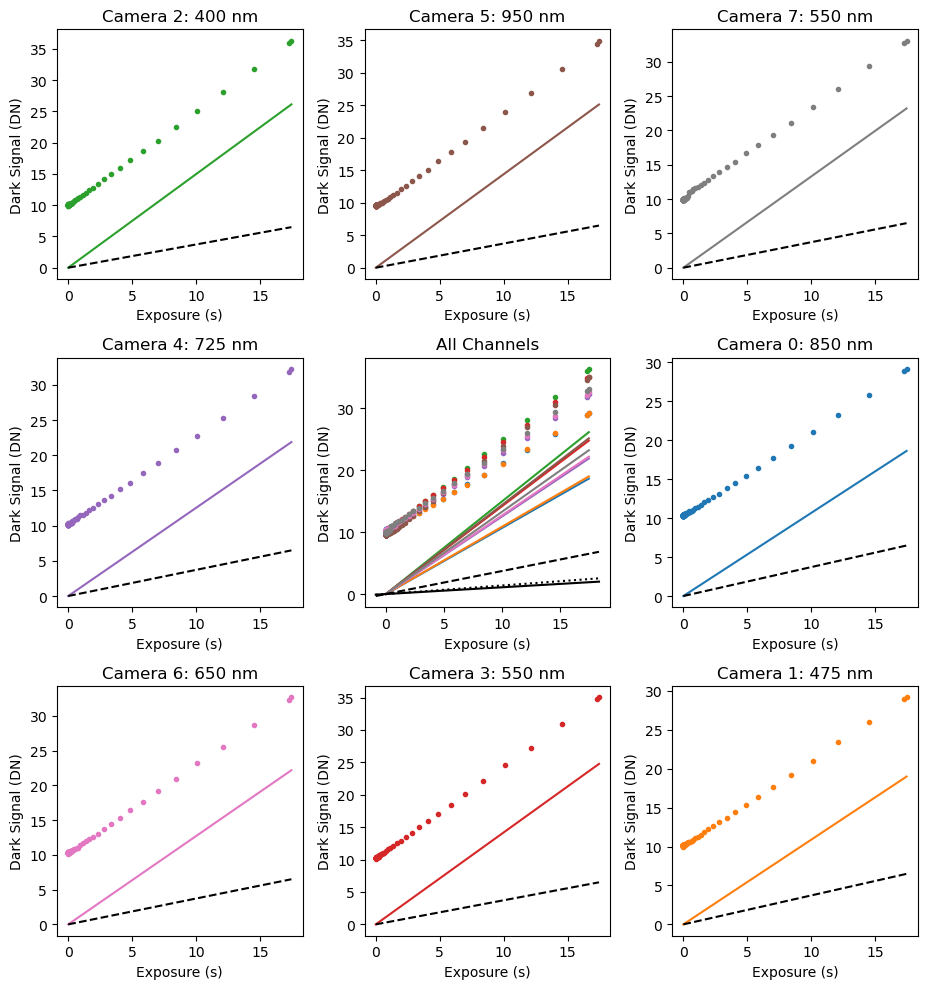

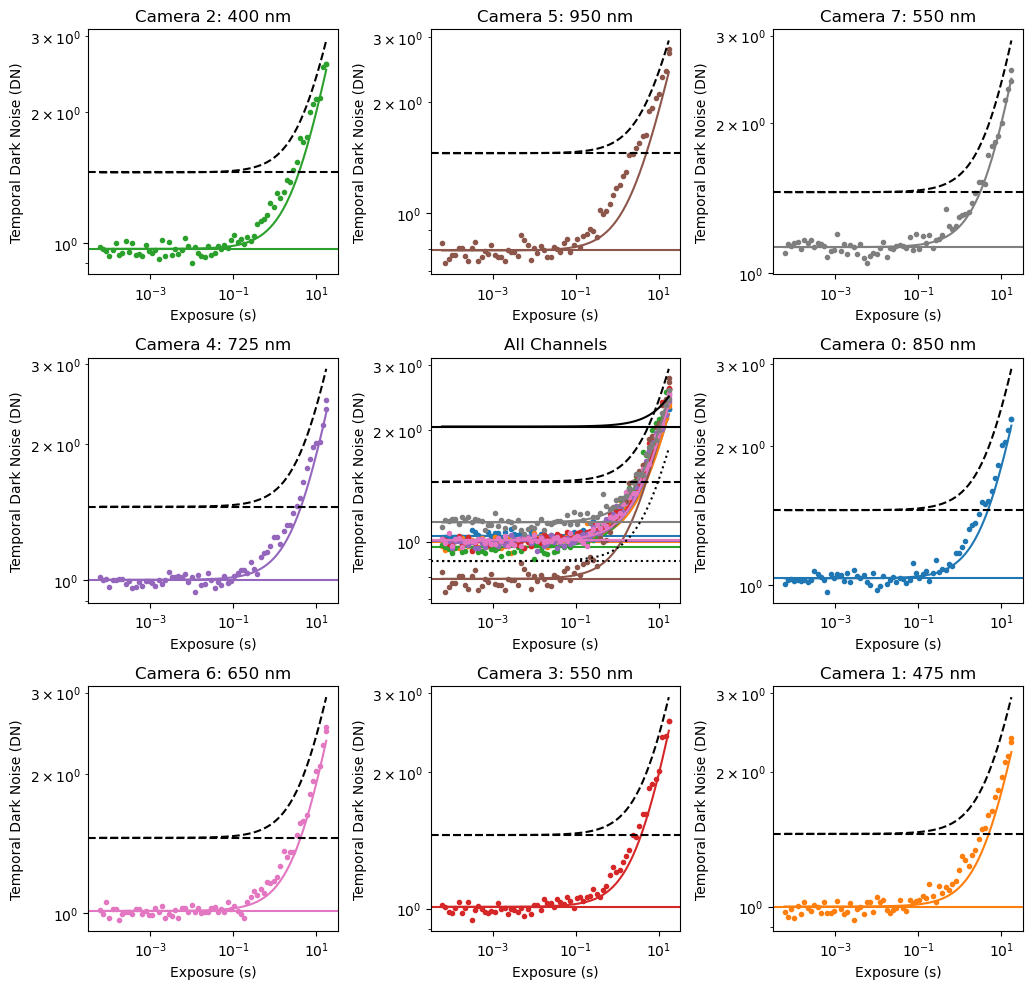

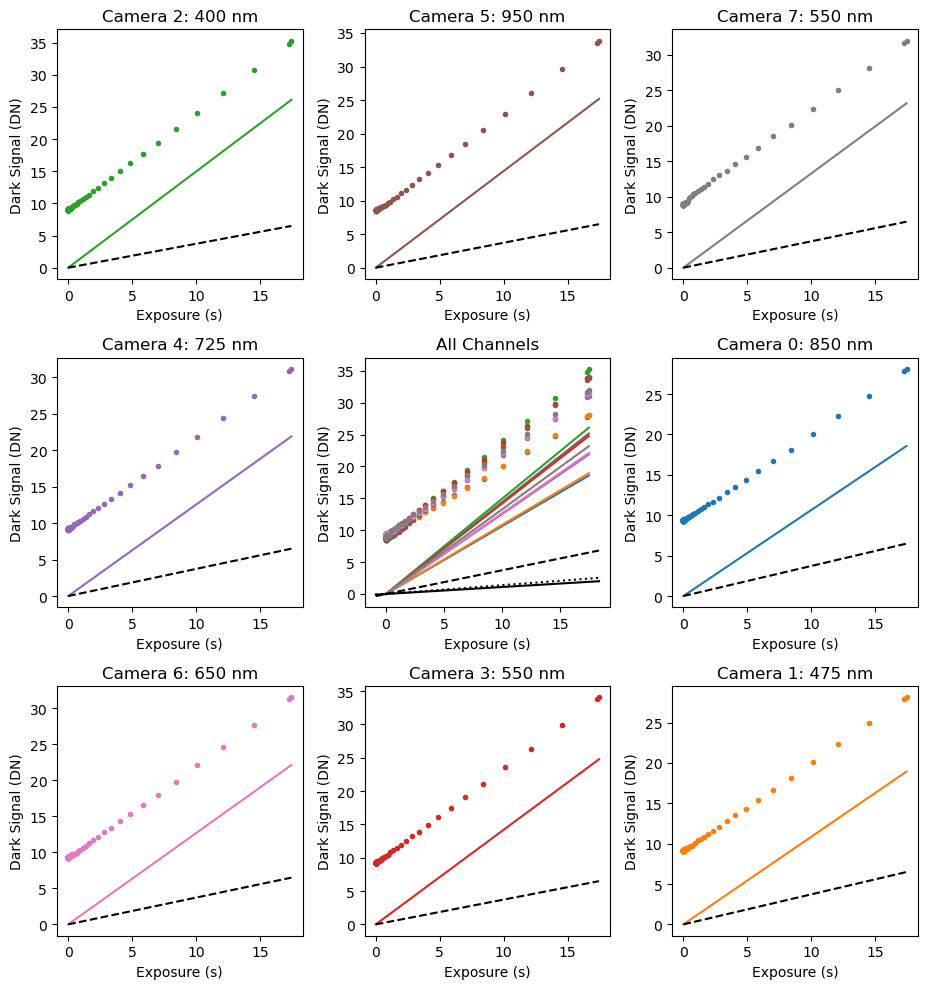

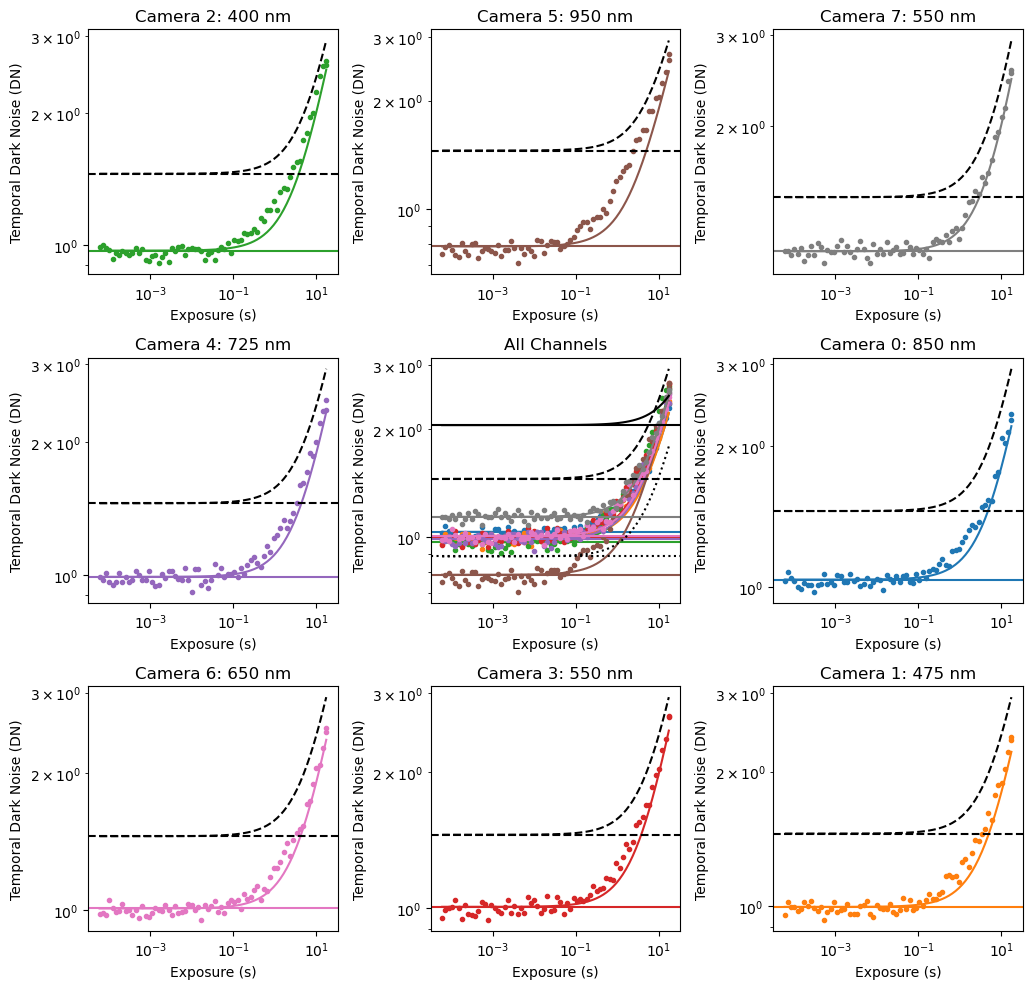

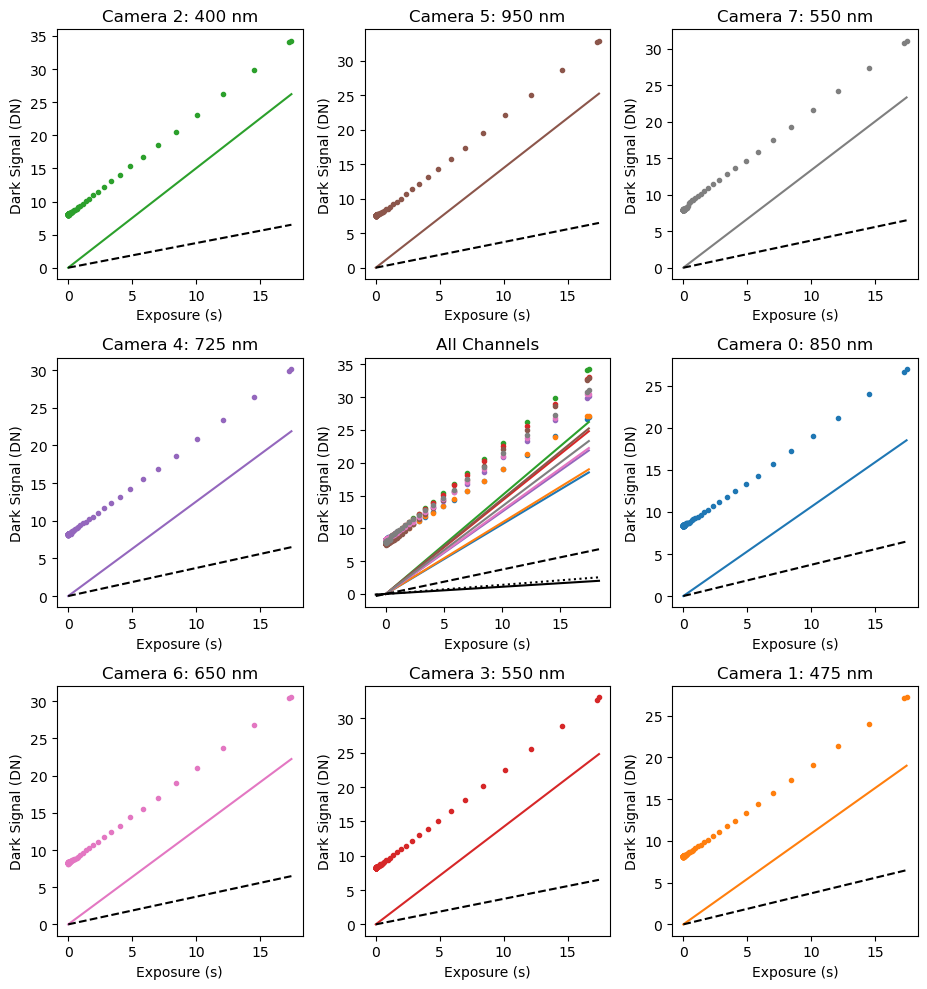

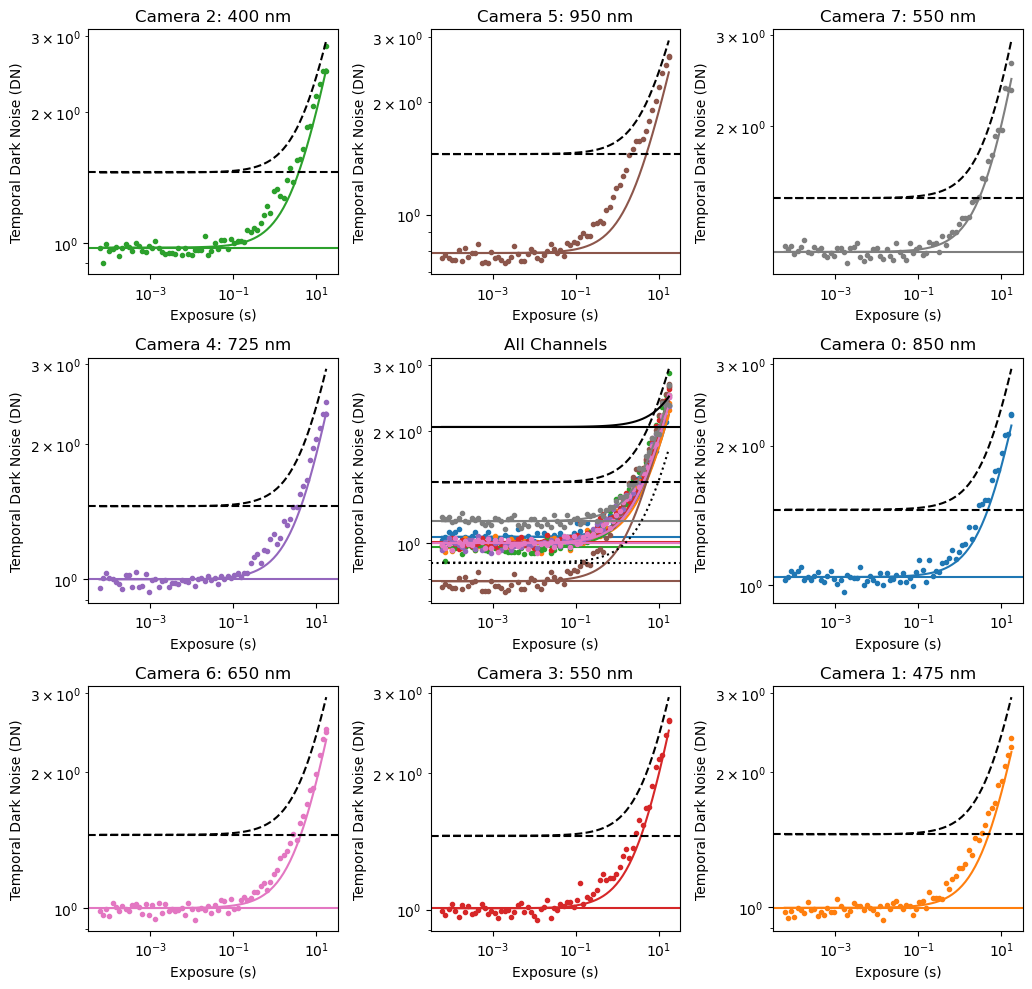

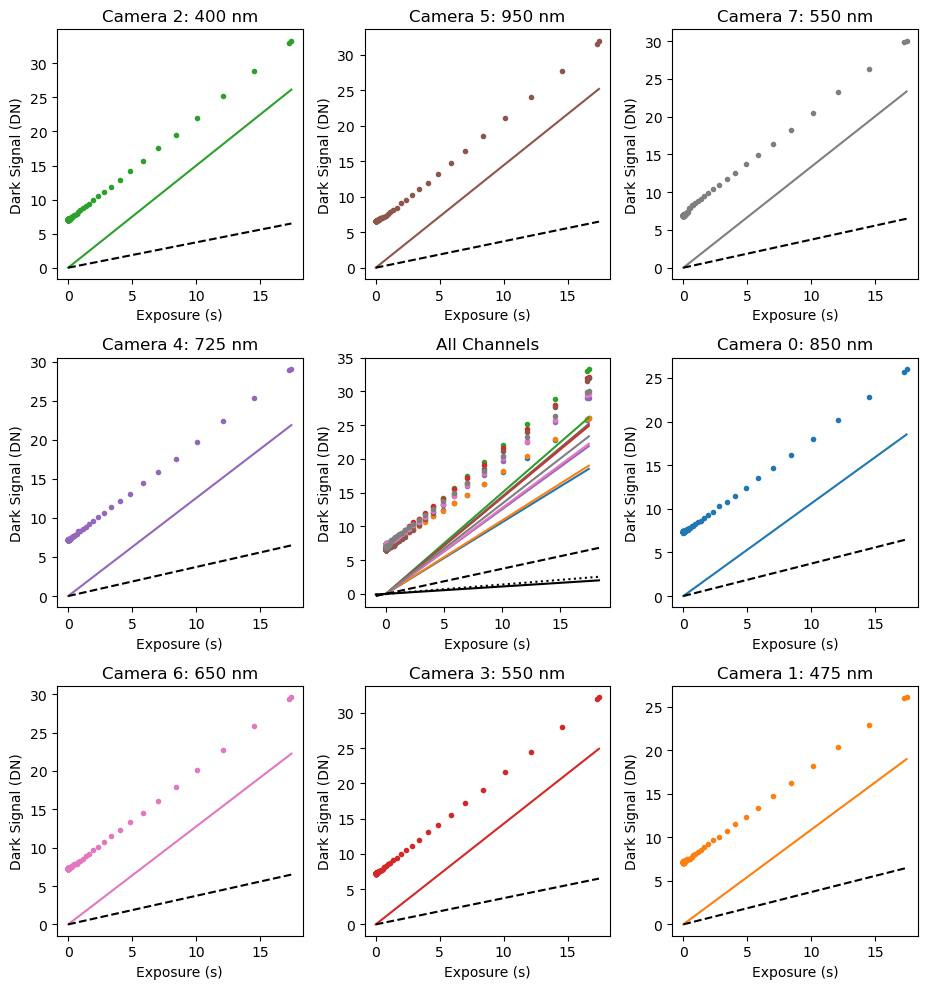

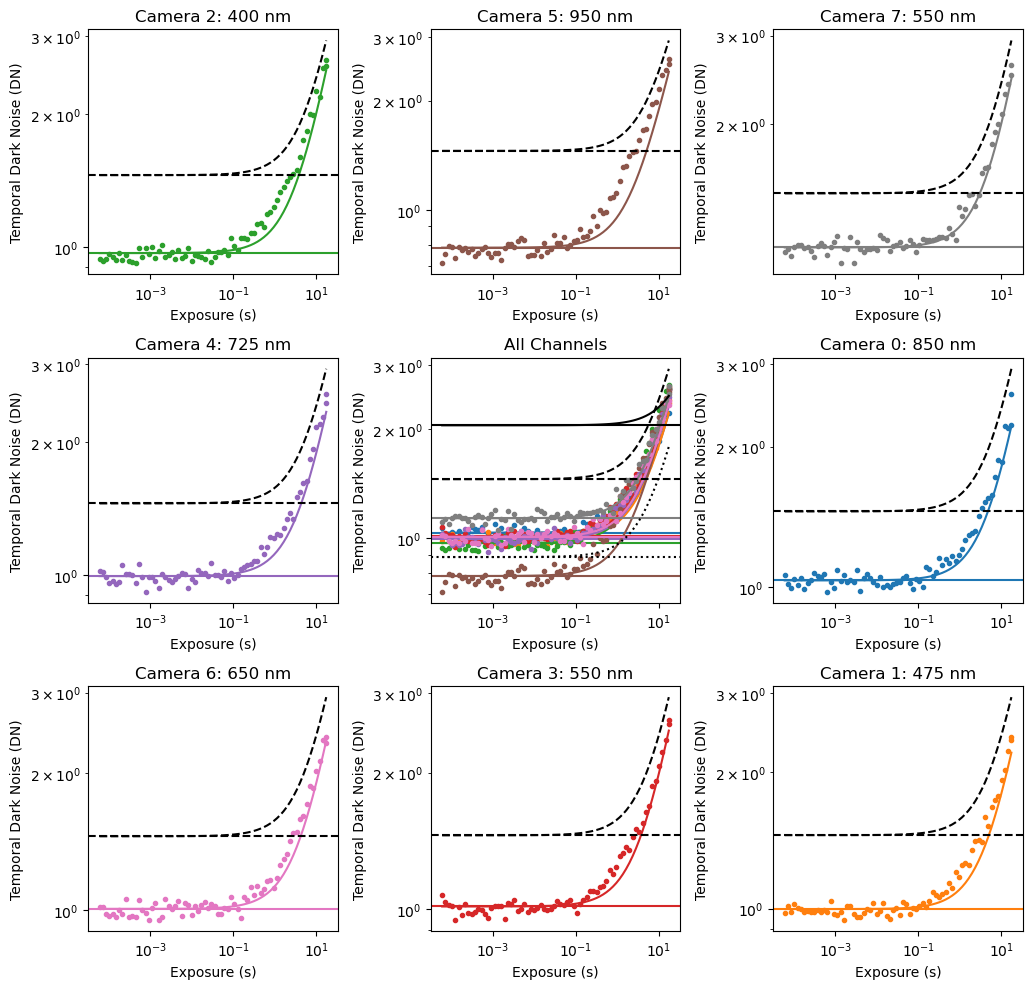

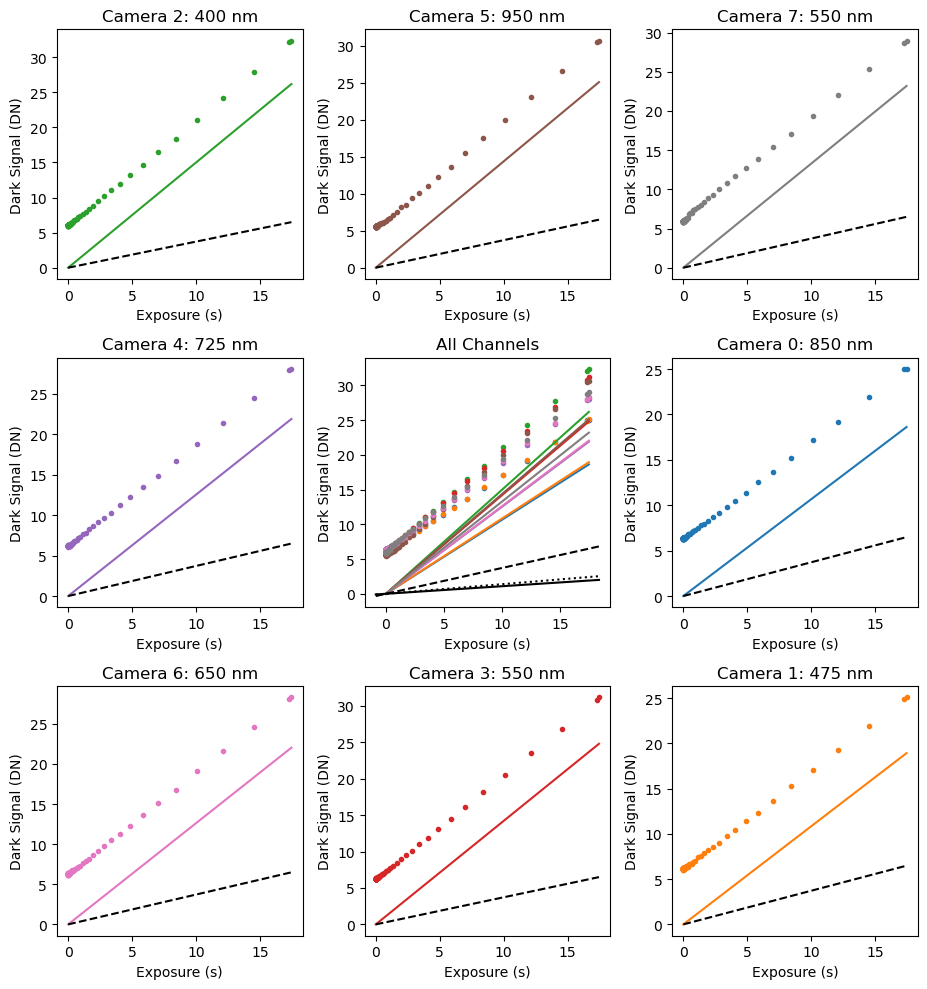

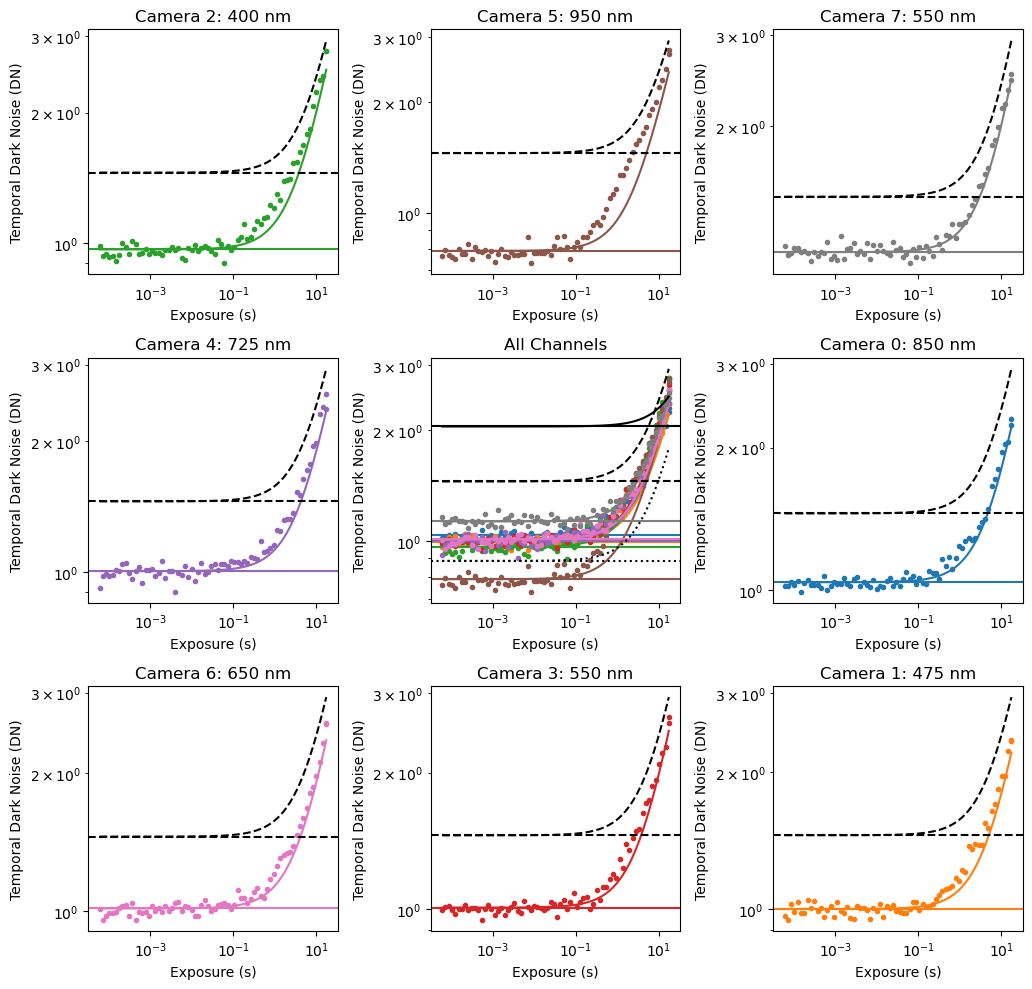

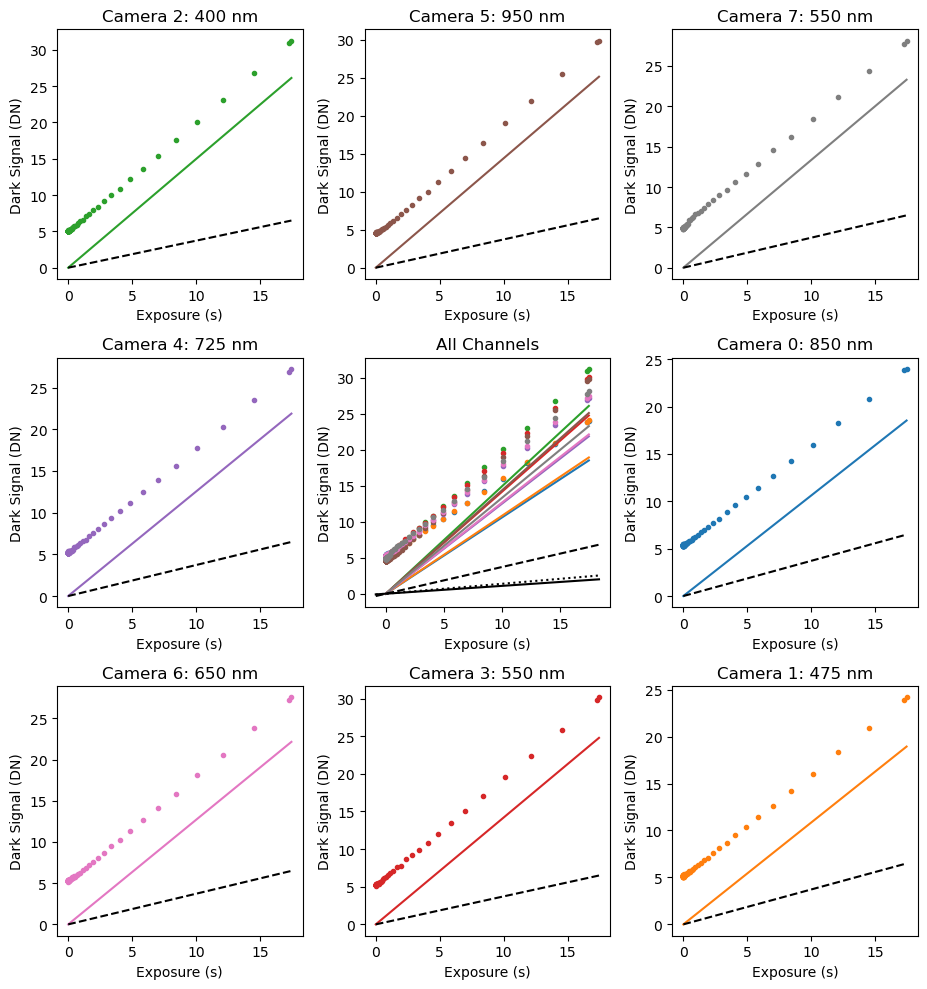

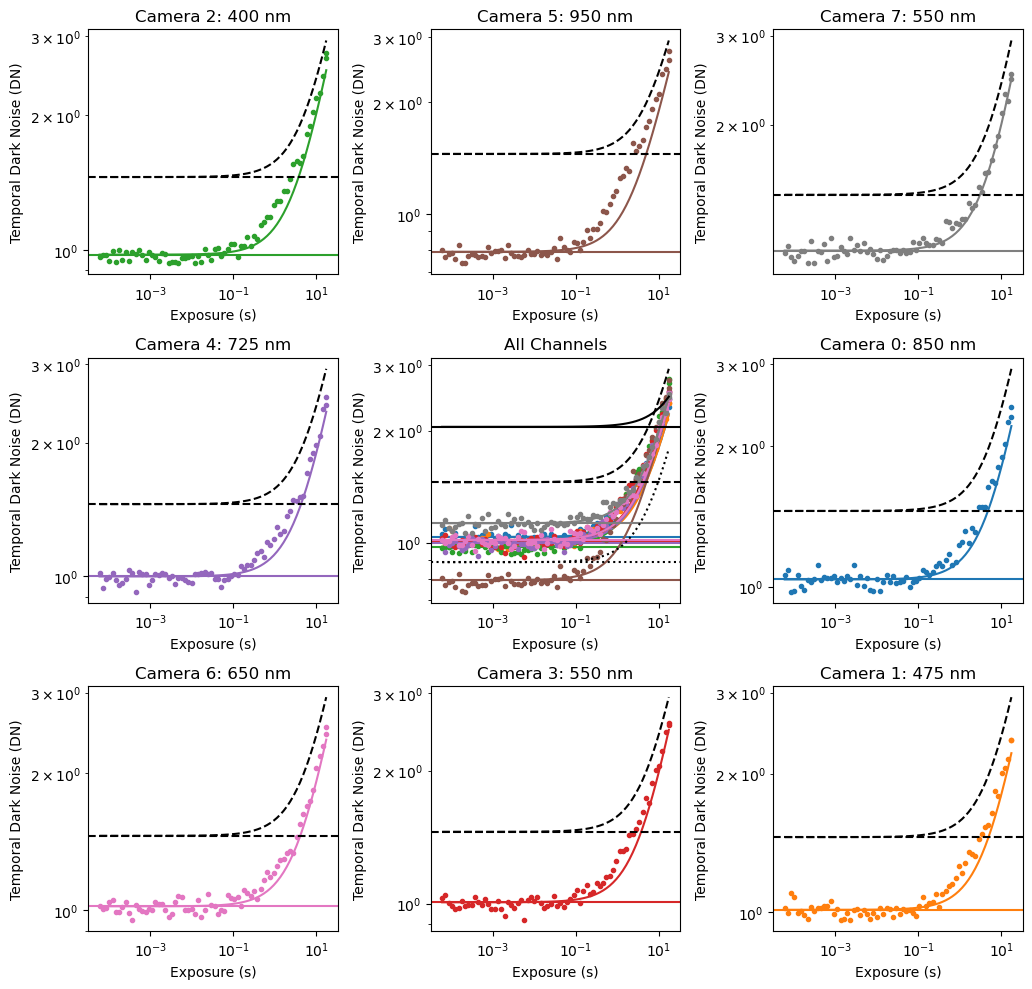

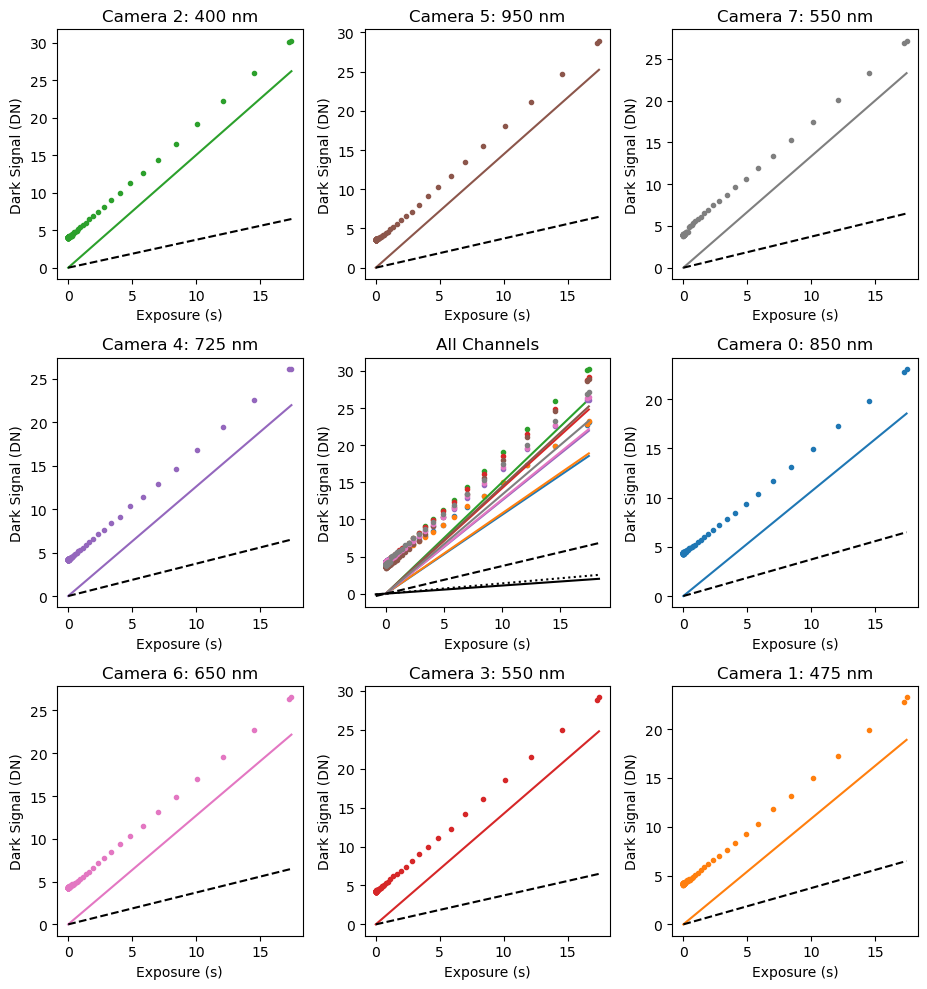

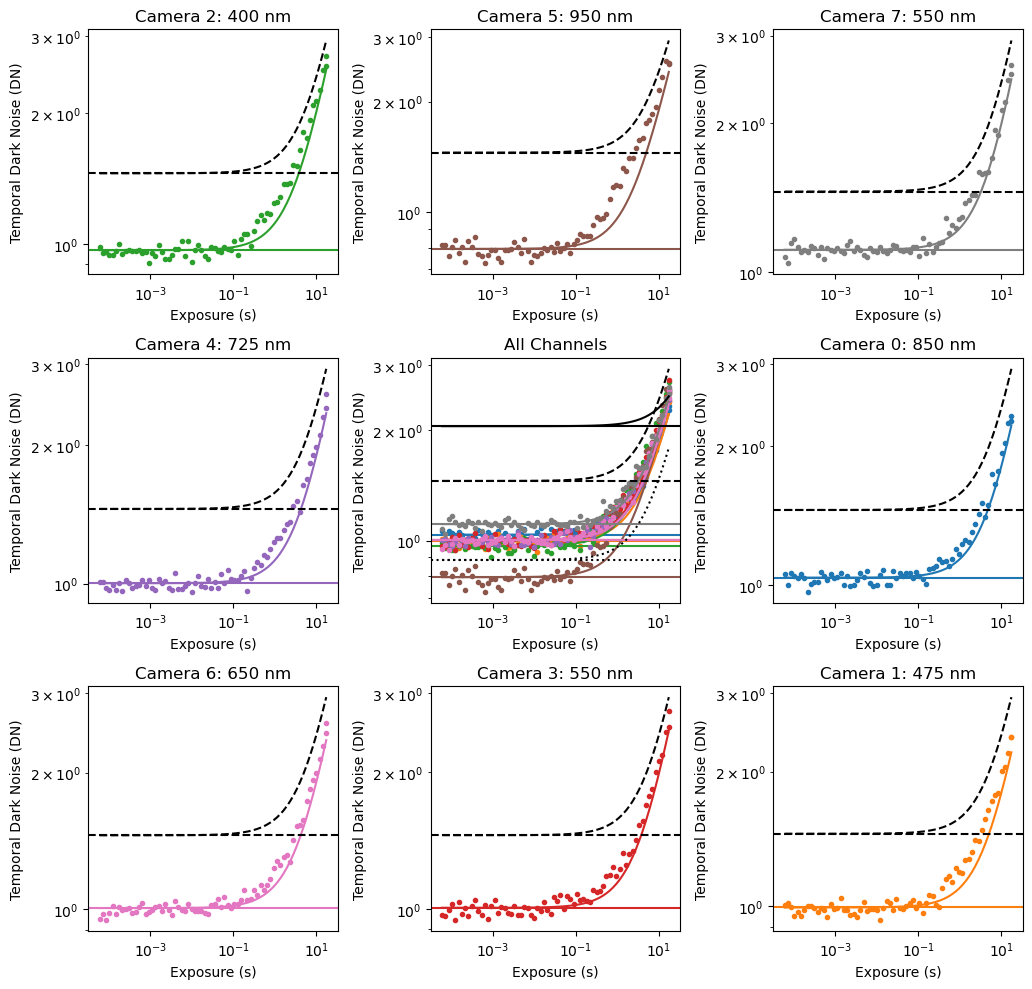

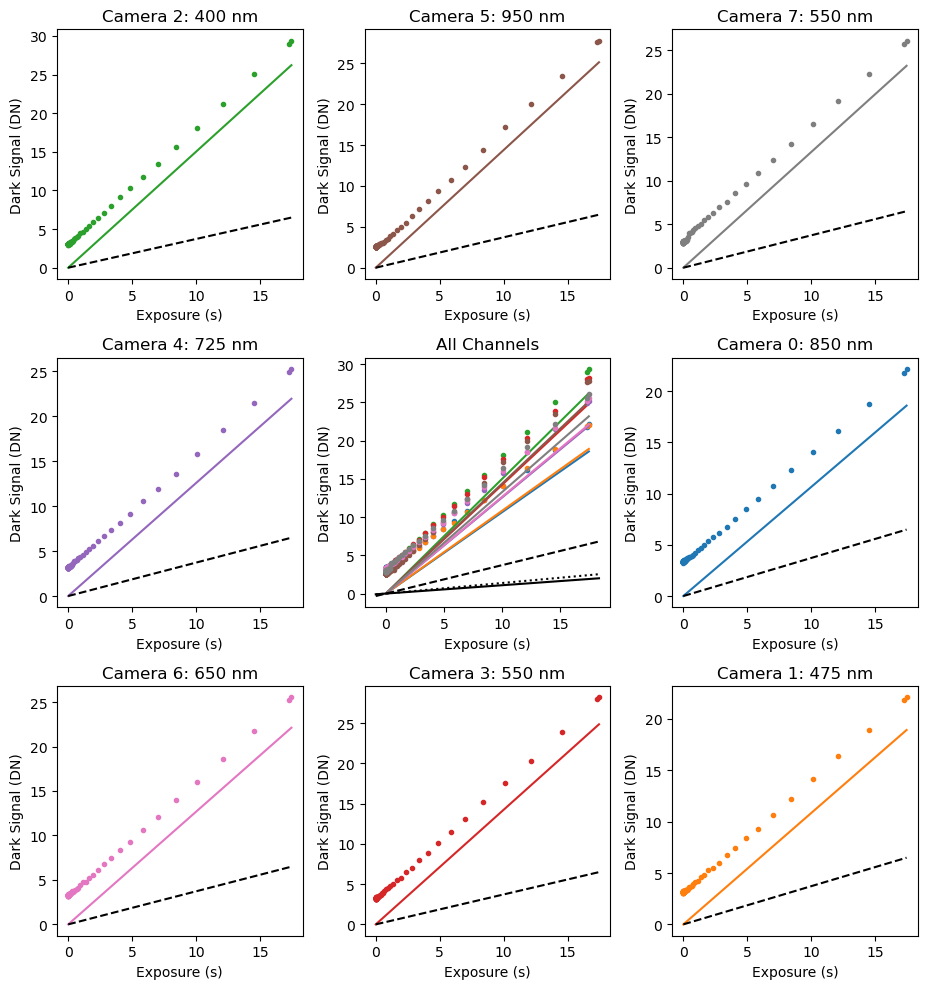

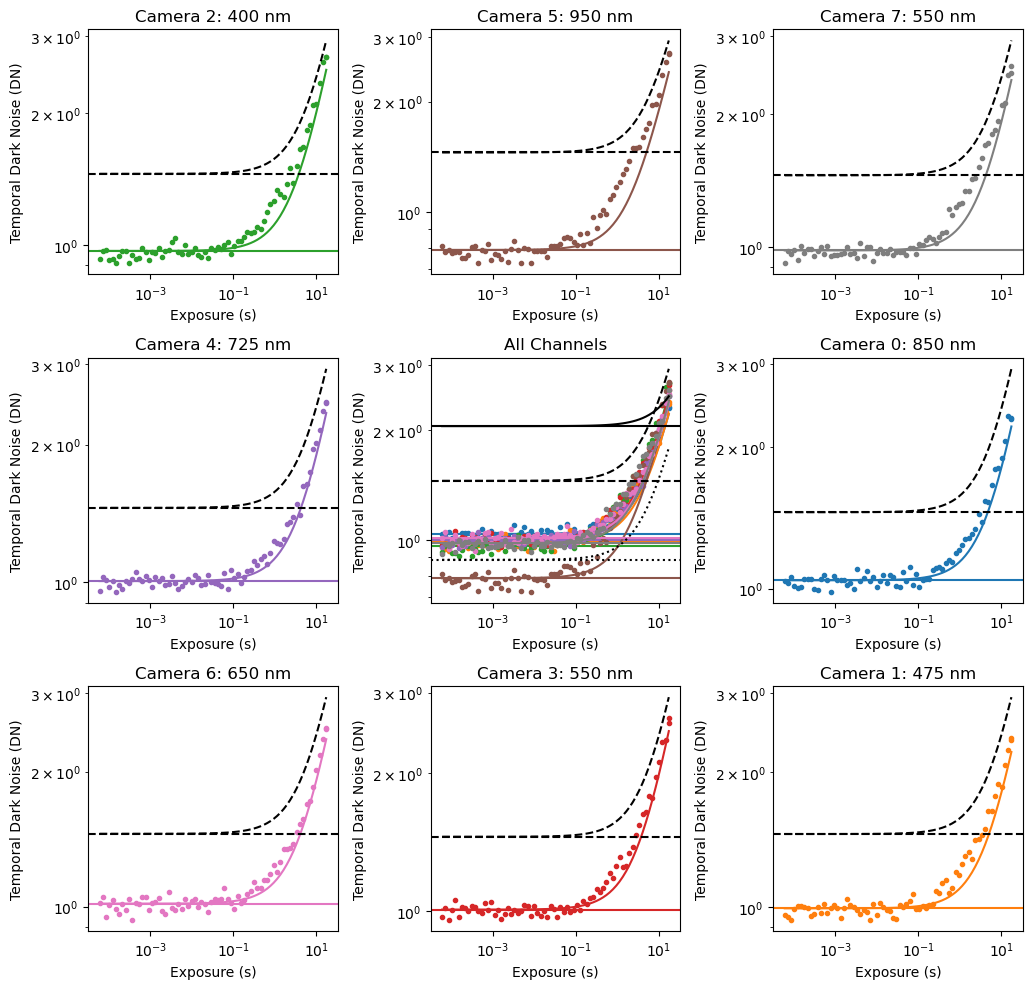

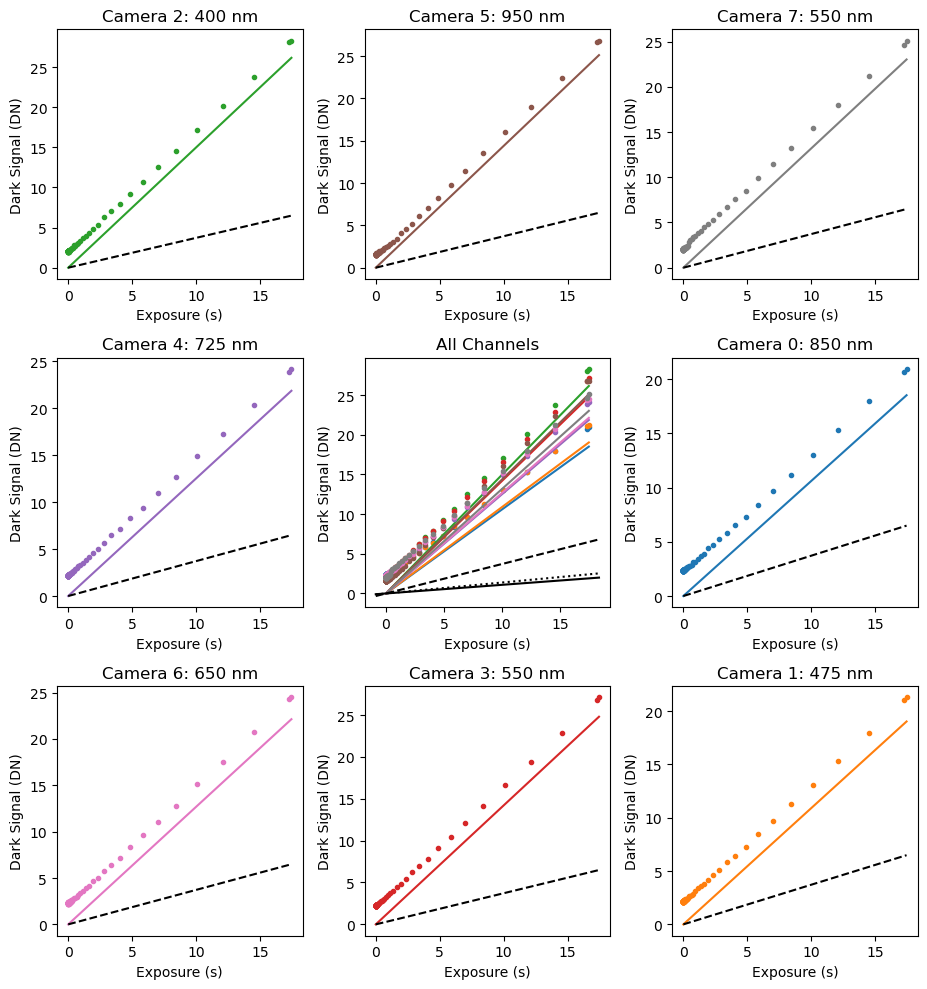

In [6]:
black_levels = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
read_noise = {}
dark_current = {}
for black_level in black_levels:
    dark = f'dark_low_{black_level}_300623'
    print('bias: ', black_level)
    results = process_dtc(dark)
    read_noise[black_level] = results['read_noise']
    dark_current[black_level] = results['dark_current']

--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------


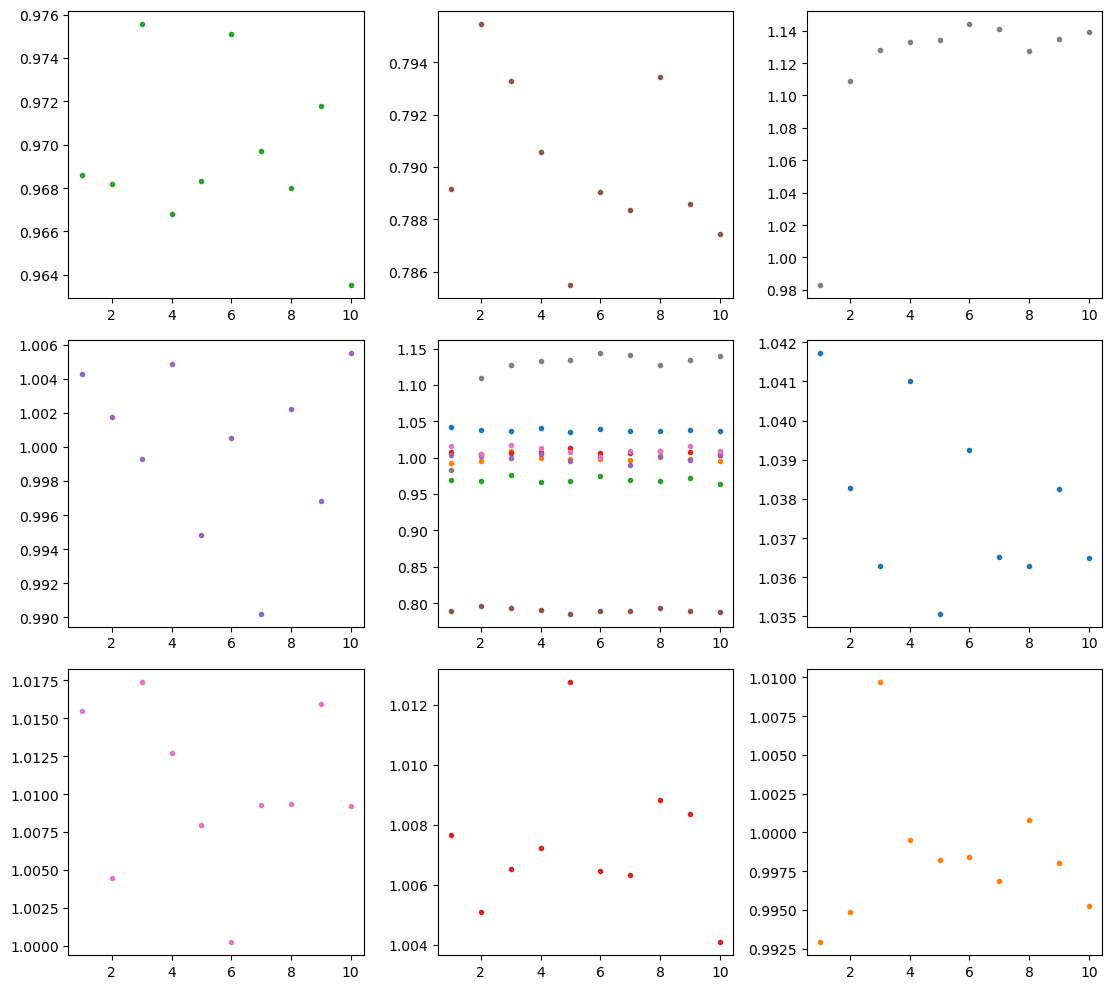

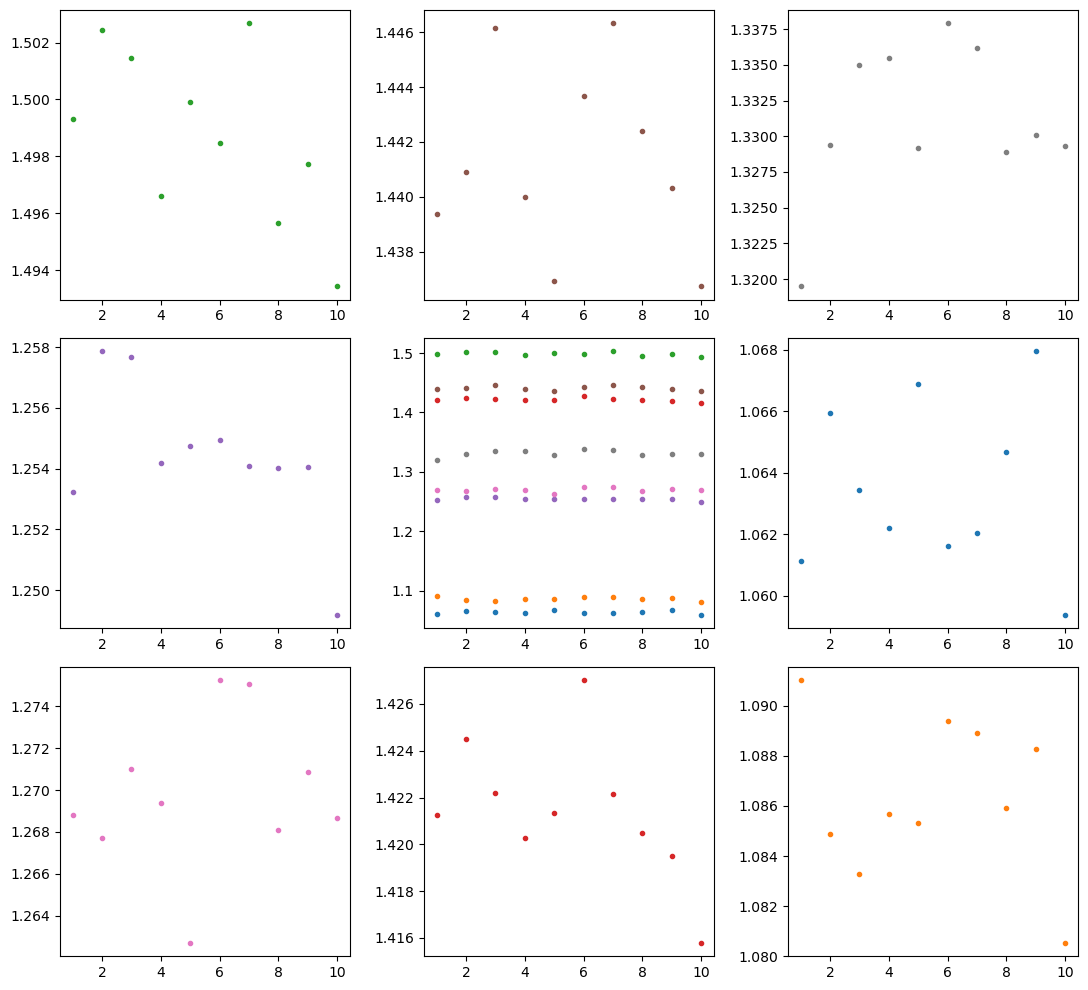

In [9]:
fig_b_exp, ax_b_exp = osp.grid_plot() # init the dark signal plot
cntr_b_exp = ax_b_exp[8] # centre plot for overlaying the dark signal

fig_dc_exp, ax_dc_exp = osp.grid_plot() # init the dark signal plot
cntr_dc_exp = ax_dc_exp[8] # centre plot for overlaying the dark signal

cameras = ['OROS-OTS', 'OROS', 'OROCHI']

channels = sorted(list(Path('..', 'data', dark).glob('[!.]*')))

black_levels = [10,9,8,7,6,5,4,3,2,1]

rn_df = pd.DataFrame(read_noise)
rn_df.index = results['camera']

dc_df = pd.DataFrame(dark_current)
dc_df.index = results['camera']

for channel_path in channels:
    channel = channel_path.name        
    print('--------------------------------------------')

    num = int(channel.split('_')[0]) # get camera number
    wvl = int(channel.split('_')[1]) # get camera wavelength        
    chnl_str = f'Camera {num}: {wvl} nm' # create channel string
    
    colour = colours(num) # get colour for channel
    # plot Dark Signal vs Exposure
    ax_b_exp[num].plot(black_levels, rn_df.loc[chnl_str], '.', label=chnl_str, color=colour)            
    cntr_b_exp.plot(black_levels, rn_df.loc[chnl_str], '.', label='All Channels', color=colour)            
    # ax_d_exp[num].set_title(chnl_str)
    # cntr_d_exp.set_title('All Channels')
    # exp_dark = dark_current * dtc_data['exposure']
    # ax_d_exp[num].plot(dtc_data['exposure'], exp_dark, linestyle='solid', color=colour, label='exp')                
    # cntr_d_exp.plot(dtc_data['exposure'], exp_dark, linestyle='solid', color=colour, label='exp')
    # ax_d_exp[num].plot(dtc_data['exposure'], (dc_exp_os_g/k_exp_os_g)*dtc_data['exposure'], linestyle='dashed', color='k', label='OROS (g)')
    # ax_d_exp[num].set_ylabel('Dark Signal (DN)')
    # ax_d_exp[num].set_xlabel('Exposure (s)')
    # cntr_d_exp.set_ylabel('Dark Signal (DN)')
    # cntr_d_exp.set_xlabel('Exposure (s)')

    ax_dc_exp[num].plot(black_levels, dc_df.loc[chnl_str], '.', label=chnl_str, color=colour)    
    cntr_dc_exp.plot(black_levels, dc_df.loc[chnl_str], '.', label='All Channels', color=colour)            
osp.show_grid(fig_b_exp, ax_b_exp)
osp.show_grid(fig_dc_exp, ax_dc_exp)

OK the basically shows there is no gain to be made from more than 1 DN except for grey...

but I didn't do 0!